In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2259832, 828)
(2259832, 8)
validation
(301336, 828)
(301336, 8)
test
(322056, 828)
(322056, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/226 [..............................] - ETA: 4:31 - loss: 2.3150 - STD: 0.0857 - MAE: 0.2205

  5/226 [..............................] - ETA: 3s - loss: 2.1279 - STD: 0.0545 - MAE: 0.2173  

  9/226 [>.............................] - ETA: 3s - loss: 2.1105 - STD: 0.0516 - MAE: 0.2168

 13/226 [>.............................] - ETA: 3s - loss: 2.0960 - STD: 0.0473 - MAE: 0.2167

 17/226 [=>............................] - ETA: 3s - loss: 2.0858 - STD: 0.0439 - MAE: 0.2167

 21/226 [=>............................] - ETA: 3s - loss: 2.0803 - STD: 0.0412 - MAE: 0.2168

 25/226 [==>...........................] - ETA: 3s - loss: 2.0751 - STD: 0.0394 - MAE: 0.2168

 29/226 [==>...........................] - ETA: 3s - loss: 2.0703 - STD: 0.0389 - MAE: 0.2167

 33/226 [===>..........................] - ETA: 3s - loss: 2.0657 - STD: 0.0386 - MAE: 0.2166

 37/226 [===>..........................] - ETA: 2s - loss: 2.0605 - STD: 0.0380 - MAE: 0.2165

 41/226 [====>.........................] - ETA: 2s - loss: 2.0531 - STD: 0.0378 - MAE: 0.2162

 45/226 [====>.........................] - ETA: 2s - loss: 2.0434 - STD: 0.0384 - MAE: 0.2159

 49/226 [=====>........................] - ETA: 2s - loss: 2.0314 - STD: 0.0400 - MAE: 0.2154

 53/226 [======>.......................] - ETA: 2s - loss: 2.0191 - STD: 0.0422 - MAE: 0.2147

 57/226 [======>.......................] - ETA: 2s - loss: 2.0060 - STD: 0.0446 - MAE: 0.2141

 61/226 [=======>......................] - ETA: 2s - loss: 1.9921 - STD: 0.0469 - MAE: 0.2134

 65/226 [=======>......................] - ETA: 4s - loss: 1.9777 - STD: 0.0491 - MAE: 0.2127

 69/226 [========>.....................] - ETA: 3s - loss: 1.9627 - STD: 0.0513 - MAE: 0.2120

 73/226 [========>.....................] - ETA: 3s - loss: 1.9473 - STD: 0.0535 - MAE: 0.2112

 77/226 [=========>....................] - ETA: 3s - loss: 1.9314 - STD: 0.0559 - MAE: 0.2103

 81/226 [=========>....................] - ETA: 3s - loss: 1.9151 - STD: 0.0584 - MAE: 0.2093

 85/226 [==========>...................] - ETA: 3s - loss: 1.8991 - STD: 0.0611 - MAE: 0.2083

 89/226 [==========>...................] - ETA: 3s - loss: 1.8833 - STD: 0.0638 - MAE: 0.2073

 93/226 [===========>..................] - ETA: 3s - loss: 1.8679 - STD: 0.0664 - MAE: 0.2063

 97/226 [===========>..................] - ETA: 2s - loss: 1.8530 - STD: 0.0690 - MAE: 0.2053

101/226 [============>.................] - ETA: 2s - loss: 1.8382 - STD: 0.0715 - MAE: 0.2043

105/226 [============>.................] - ETA: 2s - loss: 1.8238 - STD: 0.0739 - MAE: 0.2033

109/226 [=============>................] - ETA: 2s - loss: 1.8101 - STD: 0.0762 - MAE: 0.2024

113/226 [==============>...............] - ETA: 2s - loss: 1.7968 - STD: 0.0784 - MAE: 0.2014

117/226 [==============>...............] - ETA: 2s - loss: 1.7839 - STD: 0.0806 - MAE: 0.2005

121/226 [===============>..............] - ETA: 2s - loss: 1.7716 - STD: 0.0826 - MAE: 0.1997

125/226 [===============>..............] - ETA: 2s - loss: 1.7596 - STD: 0.0846 - MAE: 0.1988

129/226 [================>.............] - ETA: 2s - loss: 1.7479 - STD: 0.0866 - MAE: 0.1980

133/226 [================>.............] - ETA: 1s - loss: 1.7367 - STD: 0.0885 - MAE: 0.1971

137/226 [=================>............] - ETA: 1s - loss: 1.7258 - STD: 0.0904 - MAE: 0.1963

141/226 [=================>............] - ETA: 1s - loss: 1.7152 - STD: 0.0921 - MAE: 0.1955

145/226 [==================>...........] - ETA: 1s - loss: 1.7049 - STD: 0.0939 - MAE: 0.1948

149/226 [==================>...........] - ETA: 1s - loss: 1.6951 - STD: 0.0956 - MAE: 0.1940

153/226 [===================>..........] - ETA: 1s - loss: 1.6857 - STD: 0.0972 - MAE: 0.1933

157/226 [===================>..........] - ETA: 1s - loss: 1.6764 - STD: 0.0988 - MAE: 0.1926

161/226 [====================>.........] - ETA: 1s - loss: 1.6673 - STD: 0.1003 - MAE: 0.1919

165/226 [====================>.........] - ETA: 1s - loss: 1.6587 - STD: 0.1018 - MAE: 0.1912

169/226 [=====================>........] - ETA: 1s - loss: 1.6507 - STD: 0.1032 - MAE: 0.1905

173/226 [=====================>........] - ETA: 1s - loss: 1.6428 - STD: 0.1046 - MAE: 0.1899

177/226 [======================>.......] - ETA: 0s - loss: 1.6353 - STD: 0.1059 - MAE: 0.1893

181/226 [=======================>......] - ETA: 0s - loss: 1.6277 - STD: 0.1072 - MAE: 0.1887

185/226 [=======================>......] - ETA: 0s - loss: 1.6202 - STD: 0.1085 - MAE: 0.1881

189/226 [========================>.....] - ETA: 0s - loss: 1.6130 - STD: 0.1097 - MAE: 0.1876

193/226 [========================>.....] - ETA: 0s - loss: 1.6059 - STD: 0.1109 - MAE: 0.1870

194/226 [========================>.....] - ETA: 0s - loss: 1.6040 - STD: 0.1111 - MAE: 0.1868

198/226 [=========================>....] - ETA: 0s - loss: 1.5972 - STD: 0.1123 - MAE: 0.1863

202/226 [=========================>....] - ETA: 0s - loss: 1.5907 - STD: 0.1134 - MAE: 0.1858

206/226 [==========================>...] - ETA: 0s - loss: 1.5843 - STD: 0.1145 - MAE: 0.1852

210/226 [==========================>...] - ETA: 0s - loss: 1.5780 - STD: 0.1155 - MAE: 0.1847

214/226 [===========================>..] - ETA: 0s - loss: 1.5717 - STD: 0.1166 - MAE: 0.1842

218/226 [===========================>..] - ETA: 0s - loss: 1.5658 - STD: 0.1176 - MAE: 0.1837

222/226 [============================>.] - ETA: 0s - loss: 1.5600 - STD: 0.1185 - MAE: 0.1833

226/226 [==============================] - ETA: 0s - loss: 1.5542 - STD: 0.1195 - MAE: 0.1828

226/226 [==============================] - 6s 23ms/step - loss: 1.5542 - STD: 0.1195 - MAE: 0.1828 - val_loss: 1.3336 - val_STD: 0.1663 - val_MAE: 0.1611


Epoch 2/10000


  1/226 [..............................] - ETA: 9s - loss: 1.2298 - STD: 0.1711 - MAE: 0.1566

  5/226 [..............................] - ETA: 3s - loss: 1.2265 - STD: 0.1745 - MAE: 0.1556

  9/226 [>.............................] - ETA: 3s - loss: 1.2278 - STD: 0.1744 - MAE: 0.1557

 13/226 [>.............................] - ETA: 3s - loss: 1.2377 - STD: 0.1745 - MAE: 0.1560

 16/226 [=>............................] - ETA: 3s - loss: 1.2378 - STD: 0.1747 - MAE: 0.1560

 20/226 [=>............................] - ETA: 3s - loss: 1.2377 - STD: 0.1748 - MAE: 0.1560

 24/226 [==>...........................] - ETA: 3s - loss: 1.2362 - STD: 0.1747 - MAE: 0.1560

 28/226 [==>...........................] - ETA: 3s - loss: 1.2328 - STD: 0.1749 - MAE: 0.1557

 32/226 [===>..........................] - ETA: 3s - loss: 1.2297 - STD: 0.1752 - MAE: 0.1555

 36/226 [===>..........................] - ETA: 2s - loss: 1.2282 - STD: 0.1755 - MAE: 0.1553

 40/226 [====>.........................] - ETA: 2s - loss: 1.2270 - STD: 0.1758 - MAE: 0.1551

 44/226 [====>.........................] - ETA: 2s - loss: 1.2250 - STD: 0.1759 - MAE: 0.1550

 48/226 [=====>........................] - ETA: 2s - loss: 1.2237 - STD: 0.1761 - MAE: 0.1549

 52/226 [=====>........................] - ETA: 2s - loss: 1.2217 - STD: 0.1762 - MAE: 0.1547

 56/226 [======>.......................] - ETA: 2s - loss: 1.2197 - STD: 0.1765 - MAE: 0.1546

 60/226 [======>.......................] - ETA: 2s - loss: 1.2173 - STD: 0.1766 - MAE: 0.1544

 64/226 [=======>......................] - ETA: 2s - loss: 1.2152 - STD: 0.1769 - MAE: 0.1542

 67/226 [=======>......................] - ETA: 2s - loss: 1.2139 - STD: 0.1770 - MAE: 0.1541

 71/226 [========>.....................] - ETA: 2s - loss: 1.2123 - STD: 0.1772 - MAE: 0.1540

 75/226 [========>.....................] - ETA: 2s - loss: 1.2103 - STD: 0.1774 - MAE: 0.1538

 79/226 [=========>....................] - ETA: 2s - loss: 1.2089 - STD: 0.1777 - MAE: 0.1536

 83/226 [==========>...................] - ETA: 2s - loss: 1.2077 - STD: 0.1779 - MAE: 0.1535

 87/226 [==========>...................] - ETA: 2s - loss: 1.2058 - STD: 0.1781 - MAE: 0.1533

 91/226 [===========>..................] - ETA: 2s - loss: 1.2043 - STD: 0.1783 - MAE: 0.1532

 95/226 [===========>..................] - ETA: 2s - loss: 1.2022 - STD: 0.1785 - MAE: 0.1530

 99/226 [============>.................] - ETA: 1s - loss: 1.2004 - STD: 0.1787 - MAE: 0.1528

103/226 [============>.................] - ETA: 1s - loss: 1.1992 - STD: 0.1789 - MAE: 0.1527

107/226 [=============>................] - ETA: 1s - loss: 1.1981 - STD: 0.1792 - MAE: 0.1526

111/226 [=============>................] - ETA: 1s - loss: 1.1965 - STD: 0.1793 - MAE: 0.1524

115/226 [==============>...............] - ETA: 1s - loss: 1.1951 - STD: 0.1795 - MAE: 0.1523

119/226 [==============>...............] - ETA: 1s - loss: 1.1947 - STD: 0.1797 - MAE: 0.1522

123/226 [===============>..............] - ETA: 1s - loss: 1.1944 - STD: 0.1799 - MAE: 0.1521

127/226 [===============>..............] - ETA: 1s - loss: 1.1932 - STD: 0.1801 - MAE: 0.1520

131/226 [================>.............] - ETA: 1s - loss: 1.1920 - STD: 0.1803 - MAE: 0.1519

135/226 [================>.............] - ETA: 1s - loss: 1.1906 - STD: 0.1804 - MAE: 0.1517

139/226 [=================>............] - ETA: 1s - loss: 1.1891 - STD: 0.1806 - MAE: 0.1516

143/226 [=================>............] - ETA: 1s - loss: 1.1876 - STD: 0.1808 - MAE: 0.1515

147/226 [==================>...........] - ETA: 1s - loss: 1.1862 - STD: 0.1809 - MAE: 0.1513

151/226 [===================>..........] - ETA: 1s - loss: 1.1846 - STD: 0.1811 - MAE: 0.1512

155/226 [===================>..........] - ETA: 1s - loss: 1.1833 - STD: 0.1813 - MAE: 0.1511

159/226 [====================>.........] - ETA: 1s - loss: 1.1821 - STD: 0.1814 - MAE: 0.1510

163/226 [====================>.........] - ETA: 0s - loss: 1.1809 - STD: 0.1816 - MAE: 0.1508

167/226 [=====================>........] - ETA: 0s - loss: 1.1794 - STD: 0.1817 - MAE: 0.1507

171/226 [=====================>........] - ETA: 0s - loss: 1.1781 - STD: 0.1819 - MAE: 0.1506

175/226 [======================>.......] - ETA: 0s - loss: 1.1767 - STD: 0.1821 - MAE: 0.1504

179/226 [======================>.......] - ETA: 0s - loss: 1.1759 - STD: 0.1823 - MAE: 0.1503

183/226 [=======================>......] - ETA: 0s - loss: 1.1747 - STD: 0.1825 - MAE: 0.1502

187/226 [=======================>......] - ETA: 0s - loss: 1.1732 - STD: 0.1826 - MAE: 0.1501

191/226 [========================>.....] - ETA: 0s - loss: 1.1717 - STD: 0.1828 - MAE: 0.1499

195/226 [========================>.....] - ETA: 0s - loss: 1.1706 - STD: 0.1829 - MAE: 0.1498

199/226 [=========================>....] - ETA: 0s - loss: 1.1695 - STD: 0.1831 - MAE: 0.1497

203/226 [=========================>....] - ETA: 0s - loss: 1.1682 - STD: 0.1833 - MAE: 0.1496

207/226 [==========================>...] - ETA: 0s - loss: 1.1670 - STD: 0.1834 - MAE: 0.1495

211/226 [===========================>..] - ETA: 0s - loss: 1.1658 - STD: 0.1836 - MAE: 0.1494

215/226 [===========================>..] - ETA: 0s - loss: 1.1648 - STD: 0.1837 - MAE: 0.1492

219/226 [============================>.] - ETA: 0s - loss: 1.1638 - STD: 0.1839 - MAE: 0.1491

223/226 [============================>.] - ETA: 0s - loss: 1.1627 - STD: 0.1841 - MAE: 0.1490

226/226 [==============================] - 4s 18ms/step - loss: 1.1619 - STD: 0.1842 - MAE: 0.1490 - val_loss: 1.2164 - val_STD: 0.1858 - val_MAE: 0.1497


Epoch 3/10000


  1/226 [..............................] - ETA: 9s - loss: 1.1018 - STD: 0.1914 - MAE: 0.1432

  5/226 [..............................] - ETA: 3s - loss: 1.1033 - STD: 0.1925 - MAE: 0.1430

  9/226 [>.............................] - ETA: 3s - loss: 1.1002 - STD: 0.1927 - MAE: 0.1427

 13/226 [>.............................] - ETA: 3s - loss: 1.0983 - STD: 0.1928 - MAE: 0.1426

 17/226 [=>............................] - ETA: 3s - loss: 1.0972 - STD: 0.1927 - MAE: 0.1425

 21/226 [=>............................] - ETA: 3s - loss: 1.0981 - STD: 0.1927 - MAE: 0.1426

 25/226 [==>...........................] - ETA: 3s - loss: 1.0964 - STD: 0.1929 - MAE: 0.1424

 29/226 [==>...........................] - ETA: 3s - loss: 1.0947 - STD: 0.1930 - MAE: 0.1423

 33/226 [===>..........................] - ETA: 2s - loss: 1.0941 - STD: 0.1930 - MAE: 0.1422

 37/226 [===>..........................] - ETA: 2s - loss: 1.0936 - STD: 0.1932 - MAE: 0.1421

 41/226 [====>.........................] - ETA: 2s - loss: 1.0932 - STD: 0.1934 - MAE: 0.1420

 45/226 [====>.........................] - ETA: 2s - loss: 1.0938 - STD: 0.1936 - MAE: 0.1420

 49/226 [=====>........................] - ETA: 2s - loss: 1.0933 - STD: 0.1937 - MAE: 0.1419

 53/226 [======>.......................] - ETA: 2s - loss: 1.0913 - STD: 0.1939 - MAE: 0.1418

 57/226 [======>.......................] - ETA: 2s - loss: 1.0903 - STD: 0.1940 - MAE: 0.1417

 61/226 [=======>......................] - ETA: 2s - loss: 1.0899 - STD: 0.1942 - MAE: 0.1416

 65/226 [=======>......................] - ETA: 2s - loss: 1.0889 - STD: 0.1943 - MAE: 0.1415

 69/226 [========>.....................] - ETA: 2s - loss: 1.0886 - STD: 0.1943 - MAE: 0.1415

 73/226 [========>.....................] - ETA: 2s - loss: 1.0880 - STD: 0.1944 - MAE: 0.1414

 77/226 [=========>....................] - ETA: 2s - loss: 1.0870 - STD: 0.1945 - MAE: 0.1413

 81/226 [=========>....................] - ETA: 2s - loss: 1.0862 - STD: 0.1946 - MAE: 0.1413

 85/226 [==========>...................] - ETA: 2s - loss: 1.0852 - STD: 0.1947 - MAE: 0.1412

 89/226 [==========>...................] - ETA: 2s - loss: 1.0839 - STD: 0.1948 - MAE: 0.1411

 93/226 [===========>..................] - ETA: 2s - loss: 1.0832 - STD: 0.1949 - MAE: 0.1410

 97/226 [===========>..................] - ETA: 1s - loss: 1.0820 - STD: 0.1950 - MAE: 0.1408

101/226 [============>.................] - ETA: 1s - loss: 1.0826 - STD: 0.1952 - MAE: 0.1408

105/226 [============>.................] - ETA: 1s - loss: 1.0825 - STD: 0.1953 - MAE: 0.1407

109/226 [=============>................] - ETA: 1s - loss: 1.0825 - STD: 0.1954 - MAE: 0.1407

113/226 [==============>...............] - ETA: 1s - loss: 1.0821 - STD: 0.1955 - MAE: 0.1407

117/226 [==============>...............] - ETA: 1s - loss: 1.0815 - STD: 0.1956 - MAE: 0.1406

121/226 [===============>..............] - ETA: 1s - loss: 1.0806 - STD: 0.1956 - MAE: 0.1405

125/226 [===============>..............] - ETA: 1s - loss: 1.0796 - STD: 0.1957 - MAE: 0.1404

129/226 [================>.............] - ETA: 1s - loss: 1.0786 - STD: 0.1958 - MAE: 0.1403

133/226 [================>.............] - ETA: 1s - loss: 1.0780 - STD: 0.1959 - MAE: 0.1403

137/226 [=================>............] - ETA: 1s - loss: 1.0771 - STD: 0.1960 - MAE: 0.1402

141/226 [=================>............] - ETA: 1s - loss: 1.0762 - STD: 0.1961 - MAE: 0.1401

145/226 [==================>...........] - ETA: 1s - loss: 1.0755 - STD: 0.1962 - MAE: 0.1400

149/226 [==================>...........] - ETA: 1s - loss: 1.0752 - STD: 0.1963 - MAE: 0.1400

153/226 [===================>..........] - ETA: 1s - loss: 1.0745 - STD: 0.1964 - MAE: 0.1399

157/226 [===================>..........] - ETA: 1s - loss: 1.0737 - STD: 0.1965 - MAE: 0.1398

161/226 [====================>.........] - ETA: 0s - loss: 1.0729 - STD: 0.1966 - MAE: 0.1397

165/226 [====================>.........] - ETA: 0s - loss: 1.0717 - STD: 0.1967 - MAE: 0.1396

169/226 [=====================>........] - ETA: 0s - loss: 1.0710 - STD: 0.1968 - MAE: 0.1396

173/226 [=====================>........] - ETA: 0s - loss: 1.0704 - STD: 0.1969 - MAE: 0.1395

177/226 [======================>.......] - ETA: 0s - loss: 1.0694 - STD: 0.1970 - MAE: 0.1394

181/226 [=======================>......] - ETA: 0s - loss: 1.0689 - STD: 0.1971 - MAE: 0.1393

185/226 [=======================>......] - ETA: 0s - loss: 1.0682 - STD: 0.1972 - MAE: 0.1392

189/226 [========================>.....] - ETA: 0s - loss: 1.0678 - STD: 0.1973 - MAE: 0.1392

193/226 [========================>.....] - ETA: 0s - loss: 1.0676 - STD: 0.1974 - MAE: 0.1391

197/226 [=========================>....] - ETA: 0s - loss: 1.0669 - STD: 0.1975 - MAE: 0.1391

201/226 [=========================>....] - ETA: 0s - loss: 1.0663 - STD: 0.1976 - MAE: 0.1390

205/226 [==========================>...] - ETA: 0s - loss: 1.0655 - STD: 0.1977 - MAE: 0.1389

209/226 [==========================>...] - ETA: 0s - loss: 1.0646 - STD: 0.1978 - MAE: 0.1388

213/226 [===========================>..] - ETA: 0s - loss: 1.0639 - STD: 0.1978 - MAE: 0.1388

217/226 [===========================>..] - ETA: 0s - loss: 1.0635 - STD: 0.1979 - MAE: 0.1387

221/226 [============================>.] - ETA: 0s - loss: 1.0636 - STD: 0.1980 - MAE: 0.1387

225/226 [============================>.] - ETA: 0s - loss: 1.0634 - STD: 0.1981 - MAE: 0.1386

226/226 [==============================] - 4s 17ms/step - loss: 1.0633 - STD: 0.1982 - MAE: 0.1386 - val_loss: 1.1680 - val_STD: 0.1988 - val_MAE: 0.1424


Epoch 4/10000


  1/226 [..............................] - ETA: 9s - loss: 1.0340 - STD: 0.2026 - MAE: 0.1352

  5/226 [..............................] - ETA: 3s - loss: 1.0328 - STD: 0.2033 - MAE: 0.1349

  9/226 [>.............................] - ETA: 3s - loss: 1.0294 - STD: 0.2032 - MAE: 0.1348

 13/226 [>.............................] - ETA: 3s - loss: 1.0263 - STD: 0.2030 - MAE: 0.1347

 17/226 [=>............................] - ETA: 3s - loss: 1.0233 - STD: 0.2028 - MAE: 0.1346

 21/226 [=>............................] - ETA: 3s - loss: 1.0223 - STD: 0.2029 - MAE: 0.1345

 25/226 [==>...........................] - ETA: 3s - loss: 1.0217 - STD: 0.2030 - MAE: 0.1345

 29/226 [==>...........................] - ETA: 3s - loss: 1.0218 - STD: 0.2030 - MAE: 0.1344

 33/226 [===>..........................] - ETA: 3s - loss: 1.0221 - STD: 0.2032 - MAE: 0.1344

 37/226 [===>..........................] - ETA: 2s - loss: 1.0227 - STD: 0.2034 - MAE: 0.1343

 41/226 [====>.........................] - ETA: 2s - loss: 1.0229 - STD: 0.2035 - MAE: 0.1343

 45/226 [====>.........................] - ETA: 2s - loss: 1.0236 - STD: 0.2036 - MAE: 0.1343

 49/226 [=====>........................] - ETA: 2s - loss: 1.0229 - STD: 0.2036 - MAE: 0.1342

 53/226 [======>.......................] - ETA: 2s - loss: 1.0216 - STD: 0.2037 - MAE: 0.1341

 57/226 [======>.......................] - ETA: 2s - loss: 1.0205 - STD: 0.2038 - MAE: 0.1340

 61/226 [=======>......................] - ETA: 2s - loss: 1.0190 - STD: 0.2039 - MAE: 0.1339

 65/226 [=======>......................] - ETA: 2s - loss: 1.0181 - STD: 0.2040 - MAE: 0.1338

 69/226 [========>.....................] - ETA: 2s - loss: 1.0172 - STD: 0.2040 - MAE: 0.1337

 73/226 [========>.....................] - ETA: 2s - loss: 1.0167 - STD: 0.2041 - MAE: 0.1337

 77/226 [=========>....................] - ETA: 2s - loss: 1.0158 - STD: 0.2043 - MAE: 0.1336

 81/226 [=========>....................] - ETA: 2s - loss: 1.0147 - STD: 0.2044 - MAE: 0.1334

 85/226 [==========>...................] - ETA: 2s - loss: 1.0143 - STD: 0.2045 - MAE: 0.1334

 89/226 [==========>...................] - ETA: 2s - loss: 1.0150 - STD: 0.2046 - MAE: 0.1334

 93/226 [===========>..................] - ETA: 2s - loss: 1.0146 - STD: 0.2047 - MAE: 0.1333

 97/226 [===========>..................] - ETA: 1s - loss: 1.0149 - STD: 0.2048 - MAE: 0.1333

101/226 [============>.................] - ETA: 1s - loss: 1.0146 - STD: 0.2049 - MAE: 0.1332

105/226 [============>.................] - ETA: 1s - loss: 1.0140 - STD: 0.2049 - MAE: 0.1332

109/226 [=============>................] - ETA: 1s - loss: 1.0135 - STD: 0.2050 - MAE: 0.1331

113/226 [==============>...............] - ETA: 1s - loss: 1.0132 - STD: 0.2050 - MAE: 0.1331

117/226 [==============>...............] - ETA: 1s - loss: 1.0127 - STD: 0.2051 - MAE: 0.1330

121/226 [===============>..............] - ETA: 1s - loss: 1.0123 - STD: 0.2052 - MAE: 0.1330

125/226 [===============>..............] - ETA: 1s - loss: 1.0121 - STD: 0.2053 - MAE: 0.1329

129/226 [================>.............] - ETA: 1s - loss: 1.0115 - STD: 0.2054 - MAE: 0.1328

133/226 [================>.............] - ETA: 1s - loss: 1.0110 - STD: 0.2054 - MAE: 0.1328

137/226 [=================>............] - ETA: 1s - loss: 1.0105 - STD: 0.2055 - MAE: 0.1327

141/226 [=================>............] - ETA: 1s - loss: 1.0099 - STD: 0.2056 - MAE: 0.1327

145/226 [==================>...........] - ETA: 1s - loss: 1.0094 - STD: 0.2056 - MAE: 0.1326

149/226 [==================>...........] - ETA: 1s - loss: 1.0090 - STD: 0.2056 - MAE: 0.1326

153/226 [===================>..........] - ETA: 1s - loss: 1.0089 - STD: 0.2057 - MAE: 0.1326

157/226 [===================>..........] - ETA: 1s - loss: 1.0083 - STD: 0.2058 - MAE: 0.1325

161/226 [====================>.........] - ETA: 1s - loss: 1.0079 - STD: 0.2058 - MAE: 0.1324

165/226 [====================>.........] - ETA: 0s - loss: 1.0073 - STD: 0.2059 - MAE: 0.1324

169/226 [=====================>........] - ETA: 0s - loss: 1.0068 - STD: 0.2060 - MAE: 0.1323

173/226 [=====================>........] - ETA: 0s - loss: 1.0065 - STD: 0.2061 - MAE: 0.1323

177/226 [======================>.......] - ETA: 0s - loss: 1.0060 - STD: 0.2061 - MAE: 0.1322

181/226 [=======================>......] - ETA: 0s - loss: 1.0054 - STD: 0.2062 - MAE: 0.1322

185/226 [=======================>......] - ETA: 0s - loss: 1.0064 - STD: 0.2063 - MAE: 0.1322

189/226 [========================>.....] - ETA: 0s - loss: 1.0068 - STD: 0.2064 - MAE: 0.1322

193/226 [========================>.....] - ETA: 0s - loss: 1.0066 - STD: 0.2064 - MAE: 0.1321

197/226 [=========================>....] - ETA: 0s - loss: 1.0064 - STD: 0.2065 - MAE: 0.1321

201/226 [=========================>....] - ETA: 0s - loss: 1.0061 - STD: 0.2065 - MAE: 0.1320

205/226 [==========================>...] - ETA: 0s - loss: 1.0057 - STD: 0.2066 - MAE: 0.1320

209/226 [==========================>...] - ETA: 0s - loss: 1.0052 - STD: 0.2066 - MAE: 0.1320

213/226 [===========================>..] - ETA: 0s - loss: 1.0046 - STD: 0.2066 - MAE: 0.1319

217/226 [===========================>..] - ETA: 0s - loss: 1.0038 - STD: 0.2067 - MAE: 0.1318

221/226 [============================>.] - ETA: 0s - loss: 1.0033 - STD: 0.2067 - MAE: 0.1318

225/226 [============================>.] - ETA: 0s - loss: 1.0027 - STD: 0.2068 - MAE: 0.1317

226/226 [==============================] - 4s 17ms/step - loss: 1.0025 - STD: 0.2068 - MAE: 0.1317 - val_loss: 1.1108 - val_STD: 0.2050 - val_MAE: 0.1372


Epoch 5/10000


  1/226 [..............................] - ETA: 10s - loss: 0.9665 - STD: 0.2108 - MAE: 0.1285

  5/226 [..............................] - ETA: 3s - loss: 0.9644 - STD: 0.2110 - MAE: 0.1279 

  9/226 [>.............................] - ETA: 3s - loss: 0.9653 - STD: 0.2113 - MAE: 0.1278

 13/226 [>.............................] - ETA: 3s - loss: 0.9649 - STD: 0.2112 - MAE: 0.1278

 17/226 [=>............................] - ETA: 3s - loss: 0.9655 - STD: 0.2112 - MAE: 0.1278

 21/226 [=>............................] - ETA: 3s - loss: 0.9665 - STD: 0.2112 - MAE: 0.1279

 25/226 [==>...........................] - ETA: 3s - loss: 0.9660 - STD: 0.2113 - MAE: 0.1278

 29/226 [==>...........................] - ETA: 3s - loss: 0.9659 - STD: 0.2113 - MAE: 0.1278

 33/226 [===>..........................] - ETA: 2s - loss: 0.9657 - STD: 0.2115 - MAE: 0.1277

 37/226 [===>..........................] - ETA: 2s - loss: 0.9658 - STD: 0.2115 - MAE: 0.1277

 41/226 [====>.........................] - ETA: 2s - loss: 0.9659 - STD: 0.2114 - MAE: 0.1277

 45/226 [====>.........................] - ETA: 2s - loss: 0.9659 - STD: 0.2115 - MAE: 0.1277

 49/226 [=====>........................] - ETA: 2s - loss: 0.9661 - STD: 0.2115 - MAE: 0.1277

 53/226 [======>.......................] - ETA: 2s - loss: 0.9652 - STD: 0.2115 - MAE: 0.1277

 57/226 [======>.......................] - ETA: 2s - loss: 0.9658 - STD: 0.2115 - MAE: 0.1277

 61/226 [=======>......................] - ETA: 2s - loss: 0.9653 - STD: 0.2116 - MAE: 0.1276

 65/226 [=======>......................] - ETA: 2s - loss: 0.9652 - STD: 0.2116 - MAE: 0.1276

 69/226 [========>.....................] - ETA: 2s - loss: 0.9652 - STD: 0.2117 - MAE: 0.1276

 73/226 [========>.....................] - ETA: 2s - loss: 0.9668 - STD: 0.2118 - MAE: 0.1276

 77/226 [=========>....................] - ETA: 2s - loss: 0.9672 - STD: 0.2118 - MAE: 0.1276

 81/226 [=========>....................] - ETA: 2s - loss: 0.9668 - STD: 0.2118 - MAE: 0.1276

 85/226 [==========>...................] - ETA: 2s - loss: 0.9660 - STD: 0.2119 - MAE: 0.1275

 89/226 [==========>...................] - ETA: 2s - loss: 0.9654 - STD: 0.2119 - MAE: 0.1275

 93/226 [===========>..................] - ETA: 2s - loss: 0.9649 - STD: 0.2119 - MAE: 0.1274

 97/226 [===========>..................] - ETA: 1s - loss: 0.9646 - STD: 0.2120 - MAE: 0.1274

101/226 [============>.................] - ETA: 1s - loss: 0.9648 - STD: 0.2120 - MAE: 0.1274

105/226 [============>.................] - ETA: 1s - loss: 0.9647 - STD: 0.2120 - MAE: 0.1274

109/226 [=============>................] - ETA: 1s - loss: 0.9643 - STD: 0.2120 - MAE: 0.1273

113/226 [==============>...............] - ETA: 1s - loss: 0.9637 - STD: 0.2121 - MAE: 0.1273

117/226 [==============>...............] - ETA: 1s - loss: 0.9635 - STD: 0.2121 - MAE: 0.1273

121/226 [===============>..............] - ETA: 1s - loss: 0.9636 - STD: 0.2121 - MAE: 0.1273

125/226 [===============>..............] - ETA: 1s - loss: 0.9632 - STD: 0.2122 - MAE: 0.1272

129/226 [================>.............] - ETA: 1s - loss: 0.9633 - STD: 0.2122 - MAE: 0.1272

133/226 [================>.............] - ETA: 1s - loss: 0.9643 - STD: 0.2123 - MAE: 0.1272

137/226 [=================>............] - ETA: 1s - loss: 0.9649 - STD: 0.2123 - MAE: 0.1272

141/226 [=================>............] - ETA: 1s - loss: 0.9651 - STD: 0.2124 - MAE: 0.1272

145/226 [==================>...........] - ETA: 1s - loss: 0.9648 - STD: 0.2124 - MAE: 0.1272

149/226 [==================>...........] - ETA: 1s - loss: 0.9643 - STD: 0.2124 - MAE: 0.1272

153/226 [===================>..........] - ETA: 1s - loss: 0.9637 - STD: 0.2124 - MAE: 0.1271

157/226 [===================>..........] - ETA: 1s - loss: 0.9632 - STD: 0.2124 - MAE: 0.1271

161/226 [====================>.........] - ETA: 0s - loss: 0.9627 - STD: 0.2125 - MAE: 0.1270

165/226 [====================>.........] - ETA: 0s - loss: 0.9623 - STD: 0.2125 - MAE: 0.1270

169/226 [=====================>........] - ETA: 0s - loss: 0.9616 - STD: 0.2125 - MAE: 0.1269

173/226 [=====================>........] - ETA: 0s - loss: 0.9614 - STD: 0.2126 - MAE: 0.1269

177/226 [======================>.......] - ETA: 0s - loss: 0.9614 - STD: 0.2126 - MAE: 0.1269

181/226 [=======================>......] - ETA: 0s - loss: 0.9611 - STD: 0.2126 - MAE: 0.1269

185/226 [=======================>......] - ETA: 0s - loss: 0.9610 - STD: 0.2127 - MAE: 0.1268

189/226 [========================>.....] - ETA: 0s - loss: 0.9608 - STD: 0.2127 - MAE: 0.1268

193/226 [========================>.....] - ETA: 0s - loss: 0.9609 - STD: 0.2127 - MAE: 0.1268

197/226 [=========================>....] - ETA: 0s - loss: 0.9607 - STD: 0.2128 - MAE: 0.1268

201/226 [=========================>....] - ETA: 0s - loss: 0.9603 - STD: 0.2129 - MAE: 0.1267

205/226 [==========================>...] - ETA: 0s - loss: 0.9601 - STD: 0.2129 - MAE: 0.1267

209/226 [==========================>...] - ETA: 0s - loss: 0.9601 - STD: 0.2129 - MAE: 0.1267

213/226 [===========================>..] - ETA: 0s - loss: 0.9601 - STD: 0.2130 - MAE: 0.1267

217/226 [===========================>..] - ETA: 0s - loss: 0.9600 - STD: 0.2130 - MAE: 0.1267

221/226 [============================>.] - ETA: 0s - loss: 0.9598 - STD: 0.2130 - MAE: 0.1266

225/226 [============================>.] - ETA: 0s - loss: 0.9592 - STD: 0.2130 - MAE: 0.1266

226/226 [==============================] - 4s 17ms/step - loss: 0.9591 - STD: 0.2130 - MAE: 0.1266 - val_loss: 1.0854 - val_STD: 0.2080 - val_MAE: 0.1345


Epoch 6/10000


  1/226 [..............................] - ETA: 9s - loss: 0.9477 - STD: 0.2151 - MAE: 0.1252

  4/226 [..............................] - ETA: 3s - loss: 0.9431 - STD: 0.2160 - MAE: 0.1245

  8/226 [>.............................] - ETA: 3s - loss: 0.9444 - STD: 0.2150 - MAE: 0.1249

 12/226 [>.............................] - ETA: 3s - loss: 0.9443 - STD: 0.2150 - MAE: 0.1249

 16/226 [=>............................] - ETA: 3s - loss: 0.9456 - STD: 0.2150 - MAE: 0.1250

 20/226 [=>............................] - ETA: 3s - loss: 0.9436 - STD: 0.2151 - MAE: 0.1248

 24/226 [==>...........................] - ETA: 3s - loss: 0.9419 - STD: 0.2151 - MAE: 0.1247

 28/226 [==>...........................] - ETA: 3s - loss: 0.9398 - STD: 0.2152 - MAE: 0.1245

 32/226 [===>..........................] - ETA: 2s - loss: 0.9383 - STD: 0.2153 - MAE: 0.1244

 36/226 [===>..........................] - ETA: 2s - loss: 0.9375 - STD: 0.2153 - MAE: 0.1243

 40/226 [====>.........................] - ETA: 2s - loss: 0.9376 - STD: 0.2154 - MAE: 0.1243

 44/226 [====>.........................] - ETA: 2s - loss: 0.9374 - STD: 0.2154 - MAE: 0.1243

 48/226 [=====>........................] - ETA: 2s - loss: 0.9364 - STD: 0.2155 - MAE: 0.1242

 52/226 [=====>........................] - ETA: 2s - loss: 0.9355 - STD: 0.2155 - MAE: 0.1241

 56/226 [======>.......................] - ETA: 2s - loss: 0.9348 - STD: 0.2156 - MAE: 0.1241

 60/226 [======>.......................] - ETA: 2s - loss: 0.9369 - STD: 0.2157 - MAE: 0.1241

 64/226 [=======>......................] - ETA: 2s - loss: 0.9365 - STD: 0.2158 - MAE: 0.1240

 68/226 [========>.....................] - ETA: 2s - loss: 0.9366 - STD: 0.2158 - MAE: 0.1240

 72/226 [========>.....................] - ETA: 2s - loss: 0.9361 - STD: 0.2159 - MAE: 0.1240

 76/226 [=========>....................] - ETA: 2s - loss: 0.9354 - STD: 0.2159 - MAE: 0.1239

 80/226 [=========>....................] - ETA: 2s - loss: 0.9345 - STD: 0.2160 - MAE: 0.1239

 84/226 [==========>...................] - ETA: 2s - loss: 0.9341 - STD: 0.2160 - MAE: 0.1238

 88/226 [==========>...................] - ETA: 2s - loss: 0.9337 - STD: 0.2160 - MAE: 0.1238

 92/226 [===========>..................] - ETA: 2s - loss: 0.9333 - STD: 0.2161 - MAE: 0.1237

 96/226 [===========>..................] - ETA: 1s - loss: 0.9334 - STD: 0.2162 - MAE: 0.1237

100/226 [============>.................] - ETA: 1s - loss: 0.9327 - STD: 0.2162 - MAE: 0.1236

104/226 [============>.................] - ETA: 1s - loss: 0.9321 - STD: 0.2163 - MAE: 0.1236

107/226 [=============>................] - ETA: 1s - loss: 0.9317 - STD: 0.2163 - MAE: 0.1235

111/226 [=============>................] - ETA: 1s - loss: 0.9311 - STD: 0.2164 - MAE: 0.1235

115/226 [==============>...............] - ETA: 1s - loss: 0.9304 - STD: 0.2164 - MAE: 0.1234

119/226 [==============>...............] - ETA: 1s - loss: 0.9301 - STD: 0.2165 - MAE: 0.1233

123/226 [===============>..............] - ETA: 1s - loss: 0.9298 - STD: 0.2166 - MAE: 0.1233

127/226 [===============>..............] - ETA: 1s - loss: 0.9292 - STD: 0.2166 - MAE: 0.1233

131/226 [================>.............] - ETA: 1s - loss: 0.9288 - STD: 0.2167 - MAE: 0.1232

135/226 [================>.............] - ETA: 1s - loss: 0.9297 - STD: 0.2167 - MAE: 0.1232

139/226 [=================>............] - ETA: 1s - loss: 0.9303 - STD: 0.2168 - MAE: 0.1232

143/226 [=================>............] - ETA: 1s - loss: 0.9306 - STD: 0.2168 - MAE: 0.1232

147/226 [==================>...........] - ETA: 1s - loss: 0.9308 - STD: 0.2168 - MAE: 0.1232

151/226 [===================>..........] - ETA: 1s - loss: 0.9309 - STD: 0.2168 - MAE: 0.1232

155/226 [===================>..........] - ETA: 1s - loss: 0.9307 - STD: 0.2168 - MAE: 0.1232

159/226 [====================>.........] - ETA: 1s - loss: 0.9306 - STD: 0.2169 - MAE: 0.1232

163/226 [====================>.........] - ETA: 0s - loss: 0.9308 - STD: 0.2169 - MAE: 0.1232

167/226 [=====================>........] - ETA: 0s - loss: 0.9307 - STD: 0.2169 - MAE: 0.1232

171/226 [=====================>........] - ETA: 0s - loss: 0.9304 - STD: 0.2169 - MAE: 0.1232

175/226 [======================>.......] - ETA: 0s - loss: 0.9300 - STD: 0.2169 - MAE: 0.1231

179/226 [======================>.......] - ETA: 0s - loss: 0.9293 - STD: 0.2170 - MAE: 0.1231

183/226 [=======================>......] - ETA: 0s - loss: 0.9288 - STD: 0.2170 - MAE: 0.1230

187/226 [=======================>......] - ETA: 0s - loss: 0.9285 - STD: 0.2171 - MAE: 0.1230

191/226 [========================>.....] - ETA: 0s - loss: 0.9278 - STD: 0.2171 - MAE: 0.1229

195/226 [========================>.....] - ETA: 0s - loss: 0.9274 - STD: 0.2171 - MAE: 0.1229

199/226 [=========================>....] - ETA: 0s - loss: 0.9273 - STD: 0.2171 - MAE: 0.1229

203/226 [=========================>....] - ETA: 0s - loss: 0.9268 - STD: 0.2172 - MAE: 0.1228

207/226 [==========================>...] - ETA: 0s - loss: 0.9266 - STD: 0.2172 - MAE: 0.1228

211/226 [===========================>..] - ETA: 0s - loss: 0.9261 - STD: 0.2173 - MAE: 0.1227

215/226 [===========================>..] - ETA: 0s - loss: 0.9257 - STD: 0.2173 - MAE: 0.1227

219/226 [============================>.] - ETA: 0s - loss: 0.9251 - STD: 0.2174 - MAE: 0.1226

223/226 [============================>.] - ETA: 0s - loss: 0.9247 - STD: 0.2174 - MAE: 0.1226

226/226 [==============================] - 4s 17ms/step - loss: 0.9243 - STD: 0.2174 - MAE: 0.1226 - val_loss: 1.0720 - val_STD: 0.2138 - val_MAE: 0.1315


Epoch 7/10000


  1/226 [..............................] - ETA: 8s - loss: 0.9046 - STD: 0.2194 - MAE: 0.1206

  4/226 [..............................] - ETA: 4s - loss: 0.8973 - STD: 0.2195 - MAE: 0.1201

  8/226 [>.............................] - ETA: 3s - loss: 0.8960 - STD: 0.2194 - MAE: 0.1200

 12/226 [>.............................] - ETA: 3s - loss: 0.8949 - STD: 0.2196 - MAE: 0.1198

 16/226 [=>............................] - ETA: 3s - loss: 0.8984 - STD: 0.2199 - MAE: 0.1199

 20/226 [=>............................] - ETA: 3s - loss: 0.8995 - STD: 0.2200 - MAE: 0.1200

 24/226 [==>...........................] - ETA: 3s - loss: 0.8990 - STD: 0.2201 - MAE: 0.1199

 28/226 [==>...........................] - ETA: 3s - loss: 0.9049 - STD: 0.2202 - MAE: 0.1202

 32/226 [===>..........................] - ETA: 3s - loss: 0.9056 - STD: 0.2203 - MAE: 0.1202

 36/226 [===>..........................] - ETA: 2s - loss: 0.9068 - STD: 0.2202 - MAE: 0.1203

 40/226 [====>.........................] - ETA: 2s - loss: 0.9071 - STD: 0.2201 - MAE: 0.1204

 44/226 [====>.........................] - ETA: 2s - loss: 0.9067 - STD: 0.2202 - MAE: 0.1204

 48/226 [=====>........................] - ETA: 2s - loss: 0.9057 - STD: 0.2202 - MAE: 0.1203

 52/226 [=====>........................] - ETA: 2s - loss: 0.9049 - STD: 0.2202 - MAE: 0.1202

 56/226 [======>.......................] - ETA: 2s - loss: 0.9053 - STD: 0.2202 - MAE: 0.1202

 60/226 [======>.......................] - ETA: 2s - loss: 0.9065 - STD: 0.2202 - MAE: 0.1203

 64/226 [=======>......................] - ETA: 2s - loss: 0.9065 - STD: 0.2202 - MAE: 0.1203

 68/226 [========>.....................] - ETA: 2s - loss: 0.9059 - STD: 0.2202 - MAE: 0.1202

 72/226 [========>.....................] - ETA: 2s - loss: 0.9056 - STD: 0.2202 - MAE: 0.1202

 76/226 [=========>....................] - ETA: 2s - loss: 0.9053 - STD: 0.2202 - MAE: 0.1202

 79/226 [=========>....................] - ETA: 2s - loss: 0.9051 - STD: 0.2202 - MAE: 0.1202

 83/226 [==========>...................] - ETA: 2s - loss: 0.9041 - STD: 0.2202 - MAE: 0.1201

 87/226 [==========>...................] - ETA: 2s - loss: 0.9031 - STD: 0.2203 - MAE: 0.1201

 91/226 [===========>..................] - ETA: 2s - loss: 0.9015 - STD: 0.2203 - MAE: 0.1199

 95/226 [===========>..................] - ETA: 2s - loss: 0.9006 - STD: 0.2203 - MAE: 0.1199

 99/226 [============>.................] - ETA: 1s - loss: 0.9000 - STD: 0.2204 - MAE: 0.1198

103/226 [============>.................] - ETA: 1s - loss: 0.8992 - STD: 0.2205 - MAE: 0.1197

107/226 [=============>................] - ETA: 1s - loss: 0.8985 - STD: 0.2205 - MAE: 0.1197

111/226 [=============>................] - ETA: 1s - loss: 0.8979 - STD: 0.2206 - MAE: 0.1196

115/226 [==============>...............] - ETA: 1s - loss: 0.8973 - STD: 0.2206 - MAE: 0.1195

119/226 [==============>...............] - ETA: 1s - loss: 0.8972 - STD: 0.2207 - MAE: 0.1195

123/226 [===============>..............] - ETA: 1s - loss: 0.8966 - STD: 0.2207 - MAE: 0.1194

127/226 [===============>..............] - ETA: 1s - loss: 0.8963 - STD: 0.2208 - MAE: 0.1194

131/226 [================>.............] - ETA: 1s - loss: 0.8966 - STD: 0.2209 - MAE: 0.1194

135/226 [================>.............] - ETA: 1s - loss: 0.8969 - STD: 0.2209 - MAE: 0.1194

139/226 [=================>............] - ETA: 1s - loss: 0.8975 - STD: 0.2209 - MAE: 0.1194

143/226 [=================>............] - ETA: 1s - loss: 0.8977 - STD: 0.2210 - MAE: 0.1194

147/226 [==================>...........] - ETA: 1s - loss: 0.8974 - STD: 0.2210 - MAE: 0.1194

151/226 [===================>..........] - ETA: 1s - loss: 0.8972 - STD: 0.2210 - MAE: 0.1194

155/226 [===================>..........] - ETA: 1s - loss: 0.8967 - STD: 0.2210 - MAE: 0.1193

159/226 [====================>.........] - ETA: 1s - loss: 0.8965 - STD: 0.2211 - MAE: 0.1193

163/226 [====================>.........] - ETA: 0s - loss: 0.8964 - STD: 0.2211 - MAE: 0.1193

167/226 [=====================>........] - ETA: 0s - loss: 0.8959 - STD: 0.2211 - MAE: 0.1192

171/226 [=====================>........] - ETA: 0s - loss: 0.8956 - STD: 0.2211 - MAE: 0.1192

175/226 [======================>.......] - ETA: 0s - loss: 0.8950 - STD: 0.2211 - MAE: 0.1192

179/226 [======================>.......] - ETA: 0s - loss: 0.8946 - STD: 0.2212 - MAE: 0.1191

183/226 [=======================>......] - ETA: 0s - loss: 0.8940 - STD: 0.2212 - MAE: 0.1191

187/226 [=======================>......] - ETA: 0s - loss: 0.8935 - STD: 0.2212 - MAE: 0.1190

191/226 [========================>.....] - ETA: 0s - loss: 0.8929 - STD: 0.2213 - MAE: 0.1190

195/226 [========================>.....] - ETA: 0s - loss: 0.8925 - STD: 0.2213 - MAE: 0.1189

199/226 [=========================>....] - ETA: 0s - loss: 0.8921 - STD: 0.2213 - MAE: 0.1189

203/226 [=========================>....] - ETA: 0s - loss: 0.8915 - STD: 0.2214 - MAE: 0.1188

207/226 [==========================>...] - ETA: 0s - loss: 0.8910 - STD: 0.2214 - MAE: 0.1188

211/226 [===========================>..] - ETA: 0s - loss: 0.8909 - STD: 0.2215 - MAE: 0.1188

215/226 [===========================>..] - ETA: 0s - loss: 0.8905 - STD: 0.2215 - MAE: 0.1187

219/226 [============================>.] - ETA: 0s - loss: 0.8901 - STD: 0.2216 - MAE: 0.1187

223/226 [============================>.] - ETA: 0s - loss: 0.8899 - STD: 0.2216 - MAE: 0.1186

226/226 [==============================] - 4s 17ms/step - loss: 0.8896 - STD: 0.2217 - MAE: 0.1186 - val_loss: 1.0787 - val_STD: 0.2172 - val_MAE: 0.1309


Epoch 8/10000


  1/226 [..............................] - ETA: 10s - loss: 0.8564 - STD: 0.2233 - MAE: 0.1155

  5/226 [..............................] - ETA: 3s - loss: 0.8729 - STD: 0.2238 - MAE: 0.1165 

  9/226 [>.............................] - ETA: 3s - loss: 0.8685 - STD: 0.2242 - MAE: 0.1161

 13/226 [>.............................] - ETA: 3s - loss: 0.8694 - STD: 0.2241 - MAE: 0.1162

 17/226 [=>............................] - ETA: 3s - loss: 0.8678 - STD: 0.2241 - MAE: 0.1162

 21/226 [=>............................] - ETA: 3s - loss: 0.8708 - STD: 0.2241 - MAE: 0.1164

 25/226 [==>...........................] - ETA: 3s - loss: 0.8710 - STD: 0.2241 - MAE: 0.1164

 29/226 [==>...........................] - ETA: 3s - loss: 0.8706 - STD: 0.2241 - MAE: 0.1164

 33/226 [===>..........................] - ETA: 3s - loss: 0.8704 - STD: 0.2241 - MAE: 0.1164

 37/226 [===>..........................] - ETA: 3s - loss: 0.8700 - STD: 0.2241 - MAE: 0.1164

 41/226 [====>.........................] - ETA: 2s - loss: 0.8713 - STD: 0.2240 - MAE: 0.1165

 45/226 [====>.........................] - ETA: 2s - loss: 0.8752 - STD: 0.2242 - MAE: 0.1166

 49/226 [=====>........................] - ETA: 2s - loss: 0.8784 - STD: 0.2242 - MAE: 0.1168

 53/226 [======>.......................] - ETA: 2s - loss: 0.8811 - STD: 0.2242 - MAE: 0.1170

 57/226 [======>.......................] - ETA: 2s - loss: 0.8815 - STD: 0.2242 - MAE: 0.1170

 61/226 [=======>......................] - ETA: 2s - loss: 0.8822 - STD: 0.2240 - MAE: 0.1171

 65/226 [=======>......................] - ETA: 2s - loss: 0.8826 - STD: 0.2240 - MAE: 0.1171

 69/226 [========>.....................] - ETA: 2s - loss: 0.8842 - STD: 0.2240 - MAE: 0.1173

 73/226 [========>.....................] - ETA: 2s - loss: 0.8847 - STD: 0.2239 - MAE: 0.1173

 77/226 [=========>....................] - ETA: 2s - loss: 0.8851 - STD: 0.2238 - MAE: 0.1174

 81/226 [=========>....................] - ETA: 2s - loss: 0.8850 - STD: 0.2238 - MAE: 0.1174

 85/226 [==========>...................] - ETA: 2s - loss: 0.8842 - STD: 0.2238 - MAE: 0.1173

 89/226 [==========>...................] - ETA: 2s - loss: 0.8831 - STD: 0.2237 - MAE: 0.1173

 93/226 [===========>..................] - ETA: 2s - loss: 0.8826 - STD: 0.2238 - MAE: 0.1172

 97/226 [===========>..................] - ETA: 2s - loss: 0.8817 - STD: 0.2238 - MAE: 0.1172

101/226 [============>.................] - ETA: 1s - loss: 0.8809 - STD: 0.2238 - MAE: 0.1171

105/226 [============>.................] - ETA: 1s - loss: 0.8806 - STD: 0.2238 - MAE: 0.1171

109/226 [=============>................] - ETA: 1s - loss: 0.8802 - STD: 0.2238 - MAE: 0.1171

113/226 [==============>...............] - ETA: 1s - loss: 0.8793 - STD: 0.2239 - MAE: 0.1170

117/226 [==============>...............] - ETA: 1s - loss: 0.8785 - STD: 0.2239 - MAE: 0.1169

121/226 [===============>..............] - ETA: 1s - loss: 0.8775 - STD: 0.2240 - MAE: 0.1168

125/226 [===============>..............] - ETA: 1s - loss: 0.8768 - STD: 0.2240 - MAE: 0.1168

129/226 [================>.............] - ETA: 1s - loss: 0.8756 - STD: 0.2241 - MAE: 0.1167

133/226 [================>.............] - ETA: 1s - loss: 0.8748 - STD: 0.2241 - MAE: 0.1166

137/226 [=================>............] - ETA: 1s - loss: 0.8741 - STD: 0.2241 - MAE: 0.1165

141/226 [=================>............] - ETA: 1s - loss: 0.8736 - STD: 0.2242 - MAE: 0.1165

145/226 [==================>...........] - ETA: 1s - loss: 0.8730 - STD: 0.2242 - MAE: 0.1164

149/226 [==================>...........] - ETA: 1s - loss: 0.8731 - STD: 0.2243 - MAE: 0.1164

153/226 [===================>..........] - ETA: 1s - loss: 0.8725 - STD: 0.2243 - MAE: 0.1164

157/226 [===================>..........] - ETA: 1s - loss: 0.8717 - STD: 0.2244 - MAE: 0.1163

161/226 [====================>.........] - ETA: 1s - loss: 0.8710 - STD: 0.2244 - MAE: 0.1162

165/226 [====================>.........] - ETA: 0s - loss: 0.8705 - STD: 0.2245 - MAE: 0.1162

169/226 [=====================>........] - ETA: 0s - loss: 0.8702 - STD: 0.2245 - MAE: 0.1161

173/226 [=====================>........] - ETA: 0s - loss: 0.8699 - STD: 0.2246 - MAE: 0.1161

177/226 [======================>.......] - ETA: 0s - loss: 0.8694 - STD: 0.2246 - MAE: 0.1160

181/226 [=======================>......] - ETA: 0s - loss: 0.8691 - STD: 0.2247 - MAE: 0.1160

185/226 [=======================>......] - ETA: 0s - loss: 0.8685 - STD: 0.2247 - MAE: 0.1160

188/226 [=======================>......] - ETA: 0s - loss: 0.8682 - STD: 0.2247 - MAE: 0.1159

192/226 [========================>.....] - ETA: 0s - loss: 0.8684 - STD: 0.2248 - MAE: 0.1159

196/226 [=========================>....] - ETA: 0s - loss: 0.8687 - STD: 0.2248 - MAE: 0.1159

200/226 [=========================>....] - ETA: 0s - loss: 0.8686 - STD: 0.2248 - MAE: 0.1159

204/226 [==========================>...] - ETA: 0s - loss: 0.8683 - STD: 0.2248 - MAE: 0.1159

208/226 [==========================>...] - ETA: 0s - loss: 0.8680 - STD: 0.2249 - MAE: 0.1158

212/226 [===========================>..] - ETA: 0s - loss: 0.8676 - STD: 0.2249 - MAE: 0.1158

216/226 [===========================>..] - ETA: 0s - loss: 0.8670 - STD: 0.2249 - MAE: 0.1158

219/226 [============================>.] - ETA: 0s - loss: 0.8666 - STD: 0.2250 - MAE: 0.1157

223/226 [============================>.] - ETA: 0s - loss: 0.8663 - STD: 0.2250 - MAE: 0.1157

226/226 [==============================] - 4s 18ms/step - loss: 0.8660 - STD: 0.2250 - MAE: 0.1157 - val_loss: 1.0669 - val_STD: 0.2202 - val_MAE: 0.1290


Epoch 9/10000


  1/226 [..............................] - ETA: 10s - loss: 0.8566 - STD: 0.2260 - MAE: 0.1144

  5/226 [..............................] - ETA: 3s - loss: 0.8508 - STD: 0.2267 - MAE: 0.1139 

  9/226 [>.............................] - ETA: 3s - loss: 0.8439 - STD: 0.2268 - MAE: 0.1135

 13/226 [>.............................] - ETA: 3s - loss: 0.8457 - STD: 0.2269 - MAE: 0.1136

 17/226 [=>............................] - ETA: 3s - loss: 0.8457 - STD: 0.2269 - MAE: 0.1136

 21/226 [=>............................] - ETA: 3s - loss: 0.8432 - STD: 0.2270 - MAE: 0.1134

 25/226 [==>...........................] - ETA: 3s - loss: 0.8414 - STD: 0.2271 - MAE: 0.1132

 29/226 [==>...........................] - ETA: 3s - loss: 0.8420 - STD: 0.2272 - MAE: 0.1133

 33/226 [===>..........................] - ETA: 3s - loss: 0.8410 - STD: 0.2272 - MAE: 0.1132

 37/226 [===>..........................] - ETA: 2s - loss: 0.8396 - STD: 0.2273 - MAE: 0.1131

 41/226 [====>.........................] - ETA: 2s - loss: 0.8391 - STD: 0.2273 - MAE: 0.1130

 45/226 [====>.........................] - ETA: 2s - loss: 0.8383 - STD: 0.2275 - MAE: 0.1128

 49/226 [=====>........................] - ETA: 2s - loss: 0.8379 - STD: 0.2276 - MAE: 0.1128

 53/226 [======>.......................] - ETA: 2s - loss: 0.8384 - STD: 0.2276 - MAE: 0.1128

 57/226 [======>.......................] - ETA: 2s - loss: 0.8383 - STD: 0.2277 - MAE: 0.1127

 61/226 [=======>......................] - ETA: 2s - loss: 0.8383 - STD: 0.2278 - MAE: 0.1127

 65/226 [=======>......................] - ETA: 2s - loss: 0.8389 - STD: 0.2278 - MAE: 0.1128

 69/226 [========>.....................] - ETA: 2s - loss: 0.8396 - STD: 0.2278 - MAE: 0.1128

 73/226 [========>.....................] - ETA: 2s - loss: 0.8409 - STD: 0.2278 - MAE: 0.1129

 77/226 [=========>....................] - ETA: 2s - loss: 0.8410 - STD: 0.2278 - MAE: 0.1129

 81/226 [=========>....................] - ETA: 2s - loss: 0.8410 - STD: 0.2278 - MAE: 0.1129

 85/226 [==========>...................] - ETA: 2s - loss: 0.8407 - STD: 0.2278 - MAE: 0.1129

 89/226 [==========>...................] - ETA: 2s - loss: 0.8404 - STD: 0.2278 - MAE: 0.1128

 93/226 [===========>..................] - ETA: 2s - loss: 0.8408 - STD: 0.2278 - MAE: 0.1129

 97/226 [===========>..................] - ETA: 2s - loss: 0.8411 - STD: 0.2278 - MAE: 0.1129

101/226 [============>.................] - ETA: 1s - loss: 0.8410 - STD: 0.2279 - MAE: 0.1128

105/226 [============>.................] - ETA: 1s - loss: 0.8414 - STD: 0.2279 - MAE: 0.1128

109/226 [=============>................] - ETA: 1s - loss: 0.8410 - STD: 0.2279 - MAE: 0.1128

113/226 [==============>...............] - ETA: 1s - loss: 0.8411 - STD: 0.2279 - MAE: 0.1128

117/226 [==============>...............] - ETA: 1s - loss: 0.8411 - STD: 0.2279 - MAE: 0.1128

121/226 [===============>..............] - ETA: 1s - loss: 0.8414 - STD: 0.2279 - MAE: 0.1128

125/226 [===============>..............] - ETA: 1s - loss: 0.8408 - STD: 0.2280 - MAE: 0.1128

129/226 [================>.............] - ETA: 1s - loss: 0.8402 - STD: 0.2280 - MAE: 0.1128

133/226 [================>.............] - ETA: 1s - loss: 0.8400 - STD: 0.2280 - MAE: 0.1127

137/226 [=================>............] - ETA: 1s - loss: 0.8397 - STD: 0.2280 - MAE: 0.1127

141/226 [=================>............] - ETA: 1s - loss: 0.8396 - STD: 0.2281 - MAE: 0.1127

145/226 [==================>...........] - ETA: 1s - loss: 0.8391 - STD: 0.2281 - MAE: 0.1126

149/226 [==================>...........] - ETA: 1s - loss: 0.8386 - STD: 0.2281 - MAE: 0.1126

153/226 [===================>..........] - ETA: 1s - loss: 0.8380 - STD: 0.2282 - MAE: 0.1125

157/226 [===================>..........] - ETA: 1s - loss: 0.8377 - STD: 0.2282 - MAE: 0.1125

161/226 [====================>.........] - ETA: 1s - loss: 0.8372 - STD: 0.2282 - MAE: 0.1124

165/226 [====================>.........] - ETA: 0s - loss: 0.8370 - STD: 0.2283 - MAE: 0.1124

169/226 [=====================>........] - ETA: 0s - loss: 0.8368 - STD: 0.2283 - MAE: 0.1124

173/226 [=====================>........] - ETA: 0s - loss: 0.8366 - STD: 0.2283 - MAE: 0.1124

177/226 [======================>.......] - ETA: 0s - loss: 0.8362 - STD: 0.2284 - MAE: 0.1123

181/226 [=======================>......] - ETA: 0s - loss: 0.8359 - STD: 0.2284 - MAE: 0.1123

185/226 [=======================>......] - ETA: 0s - loss: 0.8360 - STD: 0.2285 - MAE: 0.1123

189/226 [========================>.....] - ETA: 0s - loss: 0.8354 - STD: 0.2285 - MAE: 0.1122

193/226 [========================>.....] - ETA: 0s - loss: 0.8351 - STD: 0.2285 - MAE: 0.1122

197/226 [=========================>....] - ETA: 0s - loss: 0.8347 - STD: 0.2285 - MAE: 0.1121

201/226 [=========================>....] - ETA: 0s - loss: 0.8347 - STD: 0.2286 - MAE: 0.1121

205/226 [==========================>...] - ETA: 0s - loss: 0.8343 - STD: 0.2286 - MAE: 0.1121

209/226 [==========================>...] - ETA: 0s - loss: 0.8342 - STD: 0.2286 - MAE: 0.1121

213/226 [===========================>..] - ETA: 0s - loss: 0.8337 - STD: 0.2287 - MAE: 0.1120

217/226 [===========================>..] - ETA: 0s - loss: 0.8332 - STD: 0.2287 - MAE: 0.1120

221/226 [============================>.] - ETA: 0s - loss: 0.8329 - STD: 0.2287 - MAE: 0.1120

225/226 [============================>.] - ETA: 0s - loss: 0.8327 - STD: 0.2288 - MAE: 0.1119

226/226 [==============================] - 4s 17ms/step - loss: 0.8327 - STD: 0.2288 - MAE: 0.1119 - val_loss: 1.0918 - val_STD: 0.2247 - val_MAE: 0.1285


Epoch 10/10000


  1/226 [..............................] - ETA: 10s - loss: 0.8029 - STD: 0.2306 - MAE: 0.1096

  5/226 [..............................] - ETA: 3s - loss: 0.8190 - STD: 0.2308 - MAE: 0.1103 

  9/226 [>.............................] - ETA: 3s - loss: 0.8174 - STD: 0.2304 - MAE: 0.1103

 13/226 [>.............................] - ETA: 3s - loss: 0.8127 - STD: 0.2303 - MAE: 0.1100

 17/226 [=>............................] - ETA: 3s - loss: 0.8118 - STD: 0.2305 - MAE: 0.1099

 21/226 [=>............................] - ETA: 3s - loss: 0.8158 - STD: 0.2303 - MAE: 0.1102

 25/226 [==>...........................] - ETA: 3s - loss: 0.8253 - STD: 0.2306 - MAE: 0.1106

 29/226 [==>...........................] - ETA: 3s - loss: 0.8330 - STD: 0.2305 - MAE: 0.1111

 33/226 [===>..........................] - ETA: 3s - loss: 0.8375 - STD: 0.2306 - MAE: 0.1114

 37/226 [===>..........................] - ETA: 2s - loss: 0.8375 - STD: 0.2305 - MAE: 0.1114

 41/226 [====>.........................] - ETA: 2s - loss: 0.8343 - STD: 0.2303 - MAE: 0.1113

 45/226 [====>.........................] - ETA: 2s - loss: 0.8322 - STD: 0.2303 - MAE: 0.1112

 49/226 [=====>........................] - ETA: 2s - loss: 0.8306 - STD: 0.2303 - MAE: 0.1111

 53/226 [======>.......................] - ETA: 2s - loss: 0.8294 - STD: 0.2303 - MAE: 0.1110

 57/226 [======>.......................] - ETA: 2s - loss: 0.8282 - STD: 0.2303 - MAE: 0.1109

 61/226 [=======>......................] - ETA: 2s - loss: 0.8263 - STD: 0.2303 - MAE: 0.1108

 65/226 [=======>......................] - ETA: 2s - loss: 0.8250 - STD: 0.2304 - MAE: 0.1107

 69/226 [========>.....................] - ETA: 2s - loss: 0.8238 - STD: 0.2304 - MAE: 0.1106

 73/226 [========>.....................] - ETA: 2s - loss: 0.8225 - STD: 0.2304 - MAE: 0.1105

 77/226 [=========>....................] - ETA: 2s - loss: 0.8213 - STD: 0.2305 - MAE: 0.1104

 81/226 [=========>....................] - ETA: 2s - loss: 0.8204 - STD: 0.2306 - MAE: 0.1103

 84/226 [==========>...................] - ETA: 2s - loss: 0.8204 - STD: 0.2306 - MAE: 0.1103

 88/226 [==========>...................] - ETA: 2s - loss: 0.8209 - STD: 0.2306 - MAE: 0.1103

 92/226 [===========>..................] - ETA: 2s - loss: 0.8210 - STD: 0.2307 - MAE: 0.1103

 96/226 [===========>..................] - ETA: 2s - loss: 0.8208 - STD: 0.2307 - MAE: 0.1103

100/226 [============>.................] - ETA: 1s - loss: 0.8204 - STD: 0.2307 - MAE: 0.1102

104/226 [============>.................] - ETA: 1s - loss: 0.8209 - STD: 0.2308 - MAE: 0.1103

108/226 [=============>................] - ETA: 1s - loss: 0.8209 - STD: 0.2308 - MAE: 0.1103

112/226 [=============>................] - ETA: 1s - loss: 0.8203 - STD: 0.2308 - MAE: 0.1102

116/226 [==============>...............] - ETA: 1s - loss: 0.8194 - STD: 0.2308 - MAE: 0.1101

120/226 [==============>...............] - ETA: 1s - loss: 0.8190 - STD: 0.2309 - MAE: 0.1101

124/226 [===============>..............] - ETA: 1s - loss: 0.8181 - STD: 0.2309 - MAE: 0.1100

128/226 [===============>..............] - ETA: 1s - loss: 0.8173 - STD: 0.2309 - MAE: 0.1100

132/226 [================>.............] - ETA: 1s - loss: 0.8166 - STD: 0.2309 - MAE: 0.1099

136/226 [=================>............] - ETA: 1s - loss: 0.8160 - STD: 0.2310 - MAE: 0.1098

140/226 [=================>............] - ETA: 1s - loss: 0.8156 - STD: 0.2310 - MAE: 0.1098

144/226 [==================>...........] - ETA: 1s - loss: 0.8150 - STD: 0.2311 - MAE: 0.1097

148/226 [==================>...........] - ETA: 1s - loss: 0.8144 - STD: 0.2312 - MAE: 0.1097

152/226 [===================>..........] - ETA: 1s - loss: 0.8141 - STD: 0.2312 - MAE: 0.1096

156/226 [===================>..........] - ETA: 1s - loss: 0.8136 - STD: 0.2312 - MAE: 0.1096

160/226 [====================>.........] - ETA: 1s - loss: 0.8147 - STD: 0.2313 - MAE: 0.1096

164/226 [====================>.........] - ETA: 0s - loss: 0.8151 - STD: 0.2313 - MAE: 0.1097

168/226 [=====================>........] - ETA: 0s - loss: 0.8156 - STD: 0.2313 - MAE: 0.1097

172/226 [=====================>........] - ETA: 0s - loss: 0.8156 - STD: 0.2314 - MAE: 0.1097

176/226 [======================>.......] - ETA: 0s - loss: 0.8153 - STD: 0.2314 - MAE: 0.1096

180/226 [======================>.......] - ETA: 0s - loss: 0.8149 - STD: 0.2314 - MAE: 0.1096

184/226 [=======================>......] - ETA: 0s - loss: 0.8145 - STD: 0.2314 - MAE: 0.1096

188/226 [=======================>......] - ETA: 0s - loss: 0.8142 - STD: 0.2314 - MAE: 0.1095

192/226 [========================>.....] - ETA: 0s - loss: 0.8137 - STD: 0.2314 - MAE: 0.1095

196/226 [=========================>....] - ETA: 0s - loss: 0.8133 - STD: 0.2314 - MAE: 0.1095

200/226 [=========================>....] - ETA: 0s - loss: 0.8130 - STD: 0.2315 - MAE: 0.1094

204/226 [==========================>...] - ETA: 0s - loss: 0.8126 - STD: 0.2315 - MAE: 0.1094

208/226 [==========================>...] - ETA: 0s - loss: 0.8120 - STD: 0.2315 - MAE: 0.1093

212/226 [===========================>..] - ETA: 0s - loss: 0.8116 - STD: 0.2316 - MAE: 0.1093

216/226 [===========================>..] - ETA: 0s - loss: 0.8112 - STD: 0.2316 - MAE: 0.1093

220/226 [============================>.] - ETA: 0s - loss: 0.8107 - STD: 0.2316 - MAE: 0.1092

224/226 [============================>.] - ETA: 0s - loss: 0.8105 - STD: 0.2317 - MAE: 0.1092

226/226 [==============================] - 4s 17ms/step - loss: 0.8104 - STD: 0.2317 - MAE: 0.1092 - val_loss: 1.1378 - val_STD: 0.2269 - val_MAE: 0.1298


Epoch 11/10000


  1/226 [..............................] - ETA: 8s - loss: 0.7935 - STD: 0.2355 - MAE: 0.1065

  5/226 [..............................] - ETA: 3s - loss: 0.7955 - STD: 0.2339 - MAE: 0.1074

  9/226 [>.............................] - ETA: 3s - loss: 0.7960 - STD: 0.2337 - MAE: 0.1074

 13/226 [>.............................] - ETA: 3s - loss: 0.7989 - STD: 0.2339 - MAE: 0.1076

 17/226 [=>............................] - ETA: 3s - loss: 0.8027 - STD: 0.2336 - MAE: 0.1079

 21/226 [=>............................] - ETA: 3s - loss: 0.8026 - STD: 0.2336 - MAE: 0.1079

 25/226 [==>...........................] - ETA: 3s - loss: 0.8031 - STD: 0.2335 - MAE: 0.1080

 29/226 [==>...........................] - ETA: 3s - loss: 0.8032 - STD: 0.2336 - MAE: 0.1079

 33/226 [===>..........................] - ETA: 2s - loss: 0.8010 - STD: 0.2336 - MAE: 0.1078

 37/226 [===>..........................] - ETA: 2s - loss: 0.7997 - STD: 0.2335 - MAE: 0.1077

 41/226 [====>.........................] - ETA: 2s - loss: 0.7990 - STD: 0.2336 - MAE: 0.1076

 45/226 [====>.........................] - ETA: 2s - loss: 0.7972 - STD: 0.2336 - MAE: 0.1075

 49/226 [=====>........................] - ETA: 2s - loss: 0.7957 - STD: 0.2336 - MAE: 0.1074

 53/226 [======>.......................] - ETA: 2s - loss: 0.7953 - STD: 0.2336 - MAE: 0.1074

 57/226 [======>.......................] - ETA: 2s - loss: 0.7943 - STD: 0.2336 - MAE: 0.1073

 61/226 [=======>......................] - ETA: 2s - loss: 0.7935 - STD: 0.2337 - MAE: 0.1072

 65/226 [=======>......................] - ETA: 2s - loss: 0.7936 - STD: 0.2337 - MAE: 0.1072

 69/226 [========>.....................] - ETA: 2s - loss: 0.7935 - STD: 0.2338 - MAE: 0.1072

 73/226 [========>.....................] - ETA: 2s - loss: 0.7948 - STD: 0.2338 - MAE: 0.1073

 77/226 [=========>....................] - ETA: 2s - loss: 0.7949 - STD: 0.2338 - MAE: 0.1072

 81/226 [=========>....................] - ETA: 2s - loss: 0.7953 - STD: 0.2338 - MAE: 0.1073

 85/226 [==========>...................] - ETA: 2s - loss: 0.7949 - STD: 0.2339 - MAE: 0.1072

 89/226 [==========>...................] - ETA: 2s - loss: 0.7945 - STD: 0.2338 - MAE: 0.1072

 93/226 [===========>..................] - ETA: 2s - loss: 0.7939 - STD: 0.2339 - MAE: 0.1072

 97/226 [===========>..................] - ETA: 1s - loss: 0.7934 - STD: 0.2338 - MAE: 0.1072

101/226 [============>.................] - ETA: 1s - loss: 0.7933 - STD: 0.2338 - MAE: 0.1071

105/226 [============>.................] - ETA: 1s - loss: 0.7928 - STD: 0.2339 - MAE: 0.1071

109/226 [=============>................] - ETA: 1s - loss: 0.7929 - STD: 0.2339 - MAE: 0.1071

113/226 [==============>...............] - ETA: 1s - loss: 0.7926 - STD: 0.2339 - MAE: 0.1071

117/226 [==============>...............] - ETA: 1s - loss: 0.7922 - STD: 0.2339 - MAE: 0.1070

121/226 [===============>..............] - ETA: 1s - loss: 0.7918 - STD: 0.2339 - MAE: 0.1070

125/226 [===============>..............] - ETA: 1s - loss: 0.7912 - STD: 0.2340 - MAE: 0.1070

129/226 [================>.............] - ETA: 1s - loss: 0.7907 - STD: 0.2340 - MAE: 0.1069

133/226 [================>.............] - ETA: 1s - loss: 0.7907 - STD: 0.2340 - MAE: 0.1069

137/226 [=================>............] - ETA: 1s - loss: 0.7905 - STD: 0.2341 - MAE: 0.1069

141/226 [=================>............] - ETA: 1s - loss: 0.7900 - STD: 0.2341 - MAE: 0.1068

145/226 [==================>...........] - ETA: 1s - loss: 0.7898 - STD: 0.2342 - MAE: 0.1068

149/226 [==================>...........] - ETA: 1s - loss: 0.7910 - STD: 0.2342 - MAE: 0.1068

153/226 [===================>..........] - ETA: 1s - loss: 0.7912 - STD: 0.2342 - MAE: 0.1068

157/226 [===================>..........] - ETA: 1s - loss: 0.7916 - STD: 0.2342 - MAE: 0.1069

161/226 [====================>.........] - ETA: 0s - loss: 0.7914 - STD: 0.2342 - MAE: 0.1068

165/226 [====================>.........] - ETA: 0s - loss: 0.7912 - STD: 0.2342 - MAE: 0.1068

169/226 [=====================>........] - ETA: 0s - loss: 0.7911 - STD: 0.2342 - MAE: 0.1068

173/226 [=====================>........] - ETA: 0s - loss: 0.7907 - STD: 0.2343 - MAE: 0.1068

177/226 [======================>.......] - ETA: 0s - loss: 0.7907 - STD: 0.2343 - MAE: 0.1068

181/226 [=======================>......] - ETA: 0s - loss: 0.7905 - STD: 0.2343 - MAE: 0.1067

184/226 [=======================>......] - ETA: 0s - loss: 0.7902 - STD: 0.2343 - MAE: 0.1067

188/226 [=======================>......] - ETA: 0s - loss: 0.7899 - STD: 0.2343 - MAE: 0.1067

192/226 [========================>.....] - ETA: 0s - loss: 0.7895 - STD: 0.2344 - MAE: 0.1067

196/226 [=========================>....] - ETA: 0s - loss: 0.7895 - STD: 0.2344 - MAE: 0.1066

200/226 [=========================>....] - ETA: 0s - loss: 0.7891 - STD: 0.2344 - MAE: 0.1066

204/226 [==========================>...] - ETA: 0s - loss: 0.7887 - STD: 0.2345 - MAE: 0.1066

208/226 [==========================>...] - ETA: 0s - loss: 0.7887 - STD: 0.2345 - MAE: 0.1066

212/226 [===========================>..] - ETA: 0s - loss: 0.7886 - STD: 0.2345 - MAE: 0.1065

216/226 [===========================>..] - ETA: 0s - loss: 0.7885 - STD: 0.2346 - MAE: 0.1065

220/226 [============================>.] - ETA: 0s - loss: 0.7882 - STD: 0.2346 - MAE: 0.1065

224/226 [============================>.] - ETA: 0s - loss: 0.7878 - STD: 0.2346 - MAE: 0.1064

226/226 [==============================] - 4s 17ms/step - loss: 0.7878 - STD: 0.2346 - MAE: 0.1064 - val_loss: 1.0815 - val_STD: 0.2270 - val_MAE: 0.1258


Epoch 12/10000


  1/226 [..............................] - ETA: 9s - loss: 0.7602 - STD: 0.2368 - MAE: 0.1038

  5/226 [..............................] - ETA: 3s - loss: 0.7815 - STD: 0.2355 - MAE: 0.1058

  9/226 [>.............................] - ETA: 3s - loss: 0.7769 - STD: 0.2358 - MAE: 0.1053

 13/226 [>.............................] - ETA: 3s - loss: 0.7724 - STD: 0.2360 - MAE: 0.1048

 17/226 [=>............................] - ETA: 3s - loss: 0.7723 - STD: 0.2360 - MAE: 0.1049

 20/226 [=>............................] - ETA: 3s - loss: 0.7703 - STD: 0.2360 - MAE: 0.1048

 24/226 [==>...........................] - ETA: 3s - loss: 0.7719 - STD: 0.2360 - MAE: 0.1048

 28/226 [==>...........................] - ETA: 3s - loss: 0.7709 - STD: 0.2360 - MAE: 0.1048

 32/226 [===>..........................] - ETA: 3s - loss: 0.7710 - STD: 0.2361 - MAE: 0.1048

 36/226 [===>..........................] - ETA: 2s - loss: 0.7707 - STD: 0.2362 - MAE: 0.1046

 40/226 [====>.........................] - ETA: 2s - loss: 0.7708 - STD: 0.2361 - MAE: 0.1047

 44/226 [====>.........................] - ETA: 2s - loss: 0.7700 - STD: 0.2363 - MAE: 0.1046

 48/226 [=====>........................] - ETA: 2s - loss: 0.7689 - STD: 0.2363 - MAE: 0.1045

 52/226 [=====>........................] - ETA: 2s - loss: 0.7708 - STD: 0.2363 - MAE: 0.1046

 56/226 [======>.......................] - ETA: 2s - loss: 0.7708 - STD: 0.2364 - MAE: 0.1045

 60/226 [======>.......................] - ETA: 2s - loss: 0.7702 - STD: 0.2364 - MAE: 0.1045

 64/226 [=======>......................] - ETA: 2s - loss: 0.7700 - STD: 0.2365 - MAE: 0.1045

 68/226 [========>.....................] - ETA: 2s - loss: 0.7695 - STD: 0.2364 - MAE: 0.1044

 72/226 [========>.....................] - ETA: 2s - loss: 0.7683 - STD: 0.2365 - MAE: 0.1043

 76/226 [=========>....................] - ETA: 2s - loss: 0.7677 - STD: 0.2365 - MAE: 0.1043

 80/226 [=========>....................] - ETA: 2s - loss: 0.7675 - STD: 0.2365 - MAE: 0.1043

 84/226 [==========>...................] - ETA: 2s - loss: 0.7673 - STD: 0.2365 - MAE: 0.1043

 88/226 [==========>...................] - ETA: 2s - loss: 0.7666 - STD: 0.2365 - MAE: 0.1042

 92/226 [===========>..................] - ETA: 2s - loss: 0.7659 - STD: 0.2365 - MAE: 0.1042

 96/226 [===========>..................] - ETA: 2s - loss: 0.7654 - STD: 0.2366 - MAE: 0.1041

100/226 [============>.................] - ETA: 1s - loss: 0.7648 - STD: 0.2366 - MAE: 0.1041

104/226 [============>.................] - ETA: 1s - loss: 0.7646 - STD: 0.2367 - MAE: 0.1040

108/226 [=============>................] - ETA: 1s - loss: 0.7642 - STD: 0.2367 - MAE: 0.1040

112/226 [=============>................] - ETA: 1s - loss: 0.7645 - STD: 0.2368 - MAE: 0.1040

116/226 [==============>...............] - ETA: 1s - loss: 0.7659 - STD: 0.2368 - MAE: 0.1040

120/226 [==============>...............] - ETA: 1s - loss: 0.7666 - STD: 0.2368 - MAE: 0.1041

124/226 [===============>..............] - ETA: 1s - loss: 0.7674 - STD: 0.2368 - MAE: 0.1041

128/226 [===============>..............] - ETA: 1s - loss: 0.7682 - STD: 0.2368 - MAE: 0.1042

132/226 [================>.............] - ETA: 1s - loss: 0.7691 - STD: 0.2368 - MAE: 0.1042

136/226 [=================>............] - ETA: 1s - loss: 0.7695 - STD: 0.2368 - MAE: 0.1043

140/226 [=================>............] - ETA: 1s - loss: 0.7697 - STD: 0.2369 - MAE: 0.1043

144/226 [==================>...........] - ETA: 1s - loss: 0.7694 - STD: 0.2368 - MAE: 0.1042

148/226 [==================>...........] - ETA: 1s - loss: 0.7689 - STD: 0.2368 - MAE: 0.1042

152/226 [===================>..........] - ETA: 1s - loss: 0.7688 - STD: 0.2368 - MAE: 0.1042

156/226 [===================>..........] - ETA: 1s - loss: 0.7684 - STD: 0.2368 - MAE: 0.1042

160/226 [====================>.........] - ETA: 1s - loss: 0.7681 - STD: 0.2368 - MAE: 0.1042

164/226 [====================>.........] - ETA: 0s - loss: 0.7683 - STD: 0.2368 - MAE: 0.1042

168/226 [=====================>........] - ETA: 0s - loss: 0.7682 - STD: 0.2369 - MAE: 0.1041

172/226 [=====================>........] - ETA: 0s - loss: 0.7684 - STD: 0.2369 - MAE: 0.1042

176/226 [======================>.......] - ETA: 0s - loss: 0.7685 - STD: 0.2369 - MAE: 0.1042

180/226 [======================>.......] - ETA: 0s - loss: 0.7683 - STD: 0.2369 - MAE: 0.1041

184/226 [=======================>......] - ETA: 0s - loss: 0.7678 - STD: 0.2369 - MAE: 0.1041

188/226 [=======================>......] - ETA: 0s - loss: 0.7675 - STD: 0.2369 - MAE: 0.1041

192/226 [========================>.....] - ETA: 0s - loss: 0.7670 - STD: 0.2369 - MAE: 0.1040

195/226 [========================>.....] - ETA: 0s - loss: 0.7666 - STD: 0.2370 - MAE: 0.1040

199/226 [=========================>....] - ETA: 0s - loss: 0.7660 - STD: 0.2370 - MAE: 0.1039

203/226 [=========================>....] - ETA: 0s - loss: 0.7656 - STD: 0.2370 - MAE: 0.1039

207/226 [==========================>...] - ETA: 0s - loss: 0.7652 - STD: 0.2370 - MAE: 0.1039

211/226 [===========================>..] - ETA: 0s - loss: 0.7648 - STD: 0.2371 - MAE: 0.1038

215/226 [===========================>..] - ETA: 0s - loss: 0.7642 - STD: 0.2371 - MAE: 0.1038

219/226 [============================>.] - ETA: 0s - loss: 0.7639 - STD: 0.2371 - MAE: 0.1037

223/226 [============================>.] - ETA: 0s - loss: 0.7637 - STD: 0.2372 - MAE: 0.1037

226/226 [==============================] - 4s 17ms/step - loss: 0.7641 - STD: 0.2372 - MAE: 0.1037 - val_loss: 1.1779 - val_STD: 0.2311 - val_MAE: 0.1289


Epoch 13/10000


  1/226 [..............................] - ETA: 9s - loss: 0.7870 - STD: 0.2411 - MAE: 0.1030

  4/226 [..............................] - ETA: 4s - loss: 0.7572 - STD: 0.2406 - MAE: 0.1016

  8/226 [>.............................] - ETA: 3s - loss: 0.7568 - STD: 0.2396 - MAE: 0.1022

 12/226 [>.............................] - ETA: 3s - loss: 0.7611 - STD: 0.2394 - MAE: 0.1025

 16/226 [=>............................] - ETA: 3s - loss: 0.7565 - STD: 0.2391 - MAE: 0.1024

 19/226 [=>............................] - ETA: 3s - loss: 0.7554 - STD: 0.2392 - MAE: 0.1023

 23/226 [==>...........................] - ETA: 3s - loss: 0.7538 - STD: 0.2392 - MAE: 0.1022

 27/226 [==>...........................] - ETA: 3s - loss: 0.7549 - STD: 0.2392 - MAE: 0.1022

 31/226 [===>..........................] - ETA: 3s - loss: 0.7561 - STD: 0.2392 - MAE: 0.1023

 35/226 [===>..........................] - ETA: 3s - loss: 0.7552 - STD: 0.2392 - MAE: 0.1022

 39/226 [====>.........................] - ETA: 3s - loss: 0.7540 - STD: 0.2392 - MAE: 0.1022

 43/226 [====>.........................] - ETA: 2s - loss: 0.7539 - STD: 0.2391 - MAE: 0.1022

 47/226 [=====>........................] - ETA: 2s - loss: 0.7546 - STD: 0.2391 - MAE: 0.1022

 51/226 [=====>........................] - ETA: 2s - loss: 0.7537 - STD: 0.2391 - MAE: 0.1022

 55/226 [======>.......................] - ETA: 2s - loss: 0.7538 - STD: 0.2390 - MAE: 0.1022

 59/226 [======>.......................] - ETA: 2s - loss: 0.7523 - STD: 0.2390 - MAE: 0.1021

 63/226 [=======>......................] - ETA: 2s - loss: 0.7517 - STD: 0.2390 - MAE: 0.1021

 67/226 [=======>......................] - ETA: 2s - loss: 0.7519 - STD: 0.2390 - MAE: 0.1021

 71/226 [========>.....................] - ETA: 2s - loss: 0.7509 - STD: 0.2390 - MAE: 0.1020

 75/226 [========>.....................] - ETA: 2s - loss: 0.7503 - STD: 0.2390 - MAE: 0.1020

 79/226 [=========>....................] - ETA: 2s - loss: 0.7508 - STD: 0.2390 - MAE: 0.1020

 83/226 [==========>...................] - ETA: 2s - loss: 0.7504 - STD: 0.2391 - MAE: 0.1020

 87/226 [==========>...................] - ETA: 2s - loss: 0.7501 - STD: 0.2391 - MAE: 0.1019

 91/226 [===========>..................] - ETA: 2s - loss: 0.7503 - STD: 0.2391 - MAE: 0.1019

 95/226 [===========>..................] - ETA: 2s - loss: 0.7506 - STD: 0.2391 - MAE: 0.1020

 99/226 [============>.................] - ETA: 2s - loss: 0.7503 - STD: 0.2391 - MAE: 0.1020

103/226 [============>.................] - ETA: 1s - loss: 0.7501 - STD: 0.2392 - MAE: 0.1019

107/226 [=============>................] - ETA: 1s - loss: 0.7502 - STD: 0.2391 - MAE: 0.1019

111/226 [=============>................] - ETA: 1s - loss: 0.7494 - STD: 0.2391 - MAE: 0.1019

115/226 [==============>...............] - ETA: 1s - loss: 0.7488 - STD: 0.2391 - MAE: 0.1019

119/226 [==============>...............] - ETA: 1s - loss: 0.7482 - STD: 0.2392 - MAE: 0.1018

123/226 [===============>..............] - ETA: 1s - loss: 0.7479 - STD: 0.2392 - MAE: 0.1018

127/226 [===============>..............] - ETA: 1s - loss: 0.7475 - STD: 0.2392 - MAE: 0.1017

131/226 [================>.............] - ETA: 1s - loss: 0.7477 - STD: 0.2392 - MAE: 0.1017

135/226 [================>.............] - ETA: 1s - loss: 0.7486 - STD: 0.2392 - MAE: 0.1018

139/226 [=================>............] - ETA: 1s - loss: 0.7488 - STD: 0.2392 - MAE: 0.1018

143/226 [=================>............] - ETA: 1s - loss: 0.7490 - STD: 0.2393 - MAE: 0.1018

147/226 [==================>...........] - ETA: 1s - loss: 0.7488 - STD: 0.2393 - MAE: 0.1018

151/226 [===================>..........] - ETA: 1s - loss: 0.7490 - STD: 0.2393 - MAE: 0.1018

155/226 [===================>..........] - ETA: 1s - loss: 0.7491 - STD: 0.2393 - MAE: 0.1018

159/226 [====================>.........] - ETA: 1s - loss: 0.7493 - STD: 0.2393 - MAE: 0.1018

163/226 [====================>.........] - ETA: 0s - loss: 0.7496 - STD: 0.2394 - MAE: 0.1018

167/226 [=====================>........] - ETA: 0s - loss: 0.7493 - STD: 0.2394 - MAE: 0.1018

171/226 [=====================>........] - ETA: 0s - loss: 0.7489 - STD: 0.2394 - MAE: 0.1018

175/226 [======================>.......] - ETA: 0s - loss: 0.7489 - STD: 0.2394 - MAE: 0.1017

179/226 [======================>.......] - ETA: 0s - loss: 0.7485 - STD: 0.2394 - MAE: 0.1017

183/226 [=======================>......] - ETA: 0s - loss: 0.7480 - STD: 0.2394 - MAE: 0.1017

187/226 [=======================>......] - ETA: 0s - loss: 0.7475 - STD: 0.2394 - MAE: 0.1016

191/226 [========================>.....] - ETA: 0s - loss: 0.7471 - STD: 0.2395 - MAE: 0.1016

195/226 [========================>.....] - ETA: 0s - loss: 0.7468 - STD: 0.2395 - MAE: 0.1016

199/226 [=========================>....] - ETA: 0s - loss: 0.7463 - STD: 0.2395 - MAE: 0.1015

203/226 [=========================>....] - ETA: 0s - loss: 0.7459 - STD: 0.2395 - MAE: 0.1015

207/226 [==========================>...] - ETA: 0s - loss: 0.7456 - STD: 0.2395 - MAE: 0.1015

211/226 [===========================>..] - ETA: 0s - loss: 0.7451 - STD: 0.2396 - MAE: 0.1014

215/226 [===========================>..] - ETA: 0s - loss: 0.7448 - STD: 0.2396 - MAE: 0.1014

219/226 [============================>.] - ETA: 0s - loss: 0.7444 - STD: 0.2396 - MAE: 0.1014

223/226 [============================>.] - ETA: 0s - loss: 0.7442 - STD: 0.2396 - MAE: 0.1013

226/226 [==============================] - 4s 17ms/step - loss: 0.7444 - STD: 0.2397 - MAE: 0.1013 - val_loss: 1.1098 - val_STD: 0.2308 - val_MAE: 0.1251


Epoch 14/10000


  1/226 [..............................] - ETA: 10s - loss: 0.7437 - STD: 0.2389 - MAE: 0.1017

  5/226 [..............................] - ETA: 3s - loss: 0.7256 - STD: 0.2410 - MAE: 0.0996 

  9/226 [>.............................] - ETA: 3s - loss: 0.7271 - STD: 0.2413 - MAE: 0.0995

 13/226 [>.............................] - ETA: 3s - loss: 0.7351 - STD: 0.2411 - MAE: 0.1001

 17/226 [=>............................] - ETA: 3s - loss: 0.7363 - STD: 0.2413 - MAE: 0.1000

 21/226 [=>............................] - ETA: 3s - loss: 0.7359 - STD: 0.2411 - MAE: 0.1001

 25/226 [==>...........................] - ETA: 3s - loss: 0.7326 - STD: 0.2411 - MAE: 0.0999

 29/226 [==>...........................] - ETA: 3s - loss: 0.7298 - STD: 0.2411 - MAE: 0.0997

 33/226 [===>..........................] - ETA: 3s - loss: 0.7292 - STD: 0.2412 - MAE: 0.0997

 37/226 [===>..........................] - ETA: 3s - loss: 0.7285 - STD: 0.2411 - MAE: 0.0996

 41/226 [====>.........................] - ETA: 2s - loss: 0.7290 - STD: 0.2412 - MAE: 0.0996

 45/226 [====>.........................] - ETA: 2s - loss: 0.7277 - STD: 0.2412 - MAE: 0.0995

 49/226 [=====>........................] - ETA: 2s - loss: 0.7265 - STD: 0.2412 - MAE: 0.0995

 53/226 [======>.......................] - ETA: 2s - loss: 0.7255 - STD: 0.2412 - MAE: 0.0994

 57/226 [======>.......................] - ETA: 2s - loss: 0.7253 - STD: 0.2413 - MAE: 0.0994

 61/226 [=======>......................] - ETA: 2s - loss: 0.7261 - STD: 0.2413 - MAE: 0.0994

 65/226 [=======>......................] - ETA: 2s - loss: 0.7257 - STD: 0.2413 - MAE: 0.0994

 69/226 [========>.....................] - ETA: 2s - loss: 0.7260 - STD: 0.2413 - MAE: 0.0994

 73/226 [========>.....................] - ETA: 2s - loss: 0.7254 - STD: 0.2413 - MAE: 0.0993

 77/226 [=========>....................] - ETA: 2s - loss: 0.7244 - STD: 0.2414 - MAE: 0.0992

 81/226 [=========>....................] - ETA: 2s - loss: 0.7240 - STD: 0.2415 - MAE: 0.0992

 85/226 [==========>...................] - ETA: 2s - loss: 0.7237 - STD: 0.2414 - MAE: 0.0992

 89/226 [==========>...................] - ETA: 2s - loss: 0.7233 - STD: 0.2415 - MAE: 0.0991

 93/226 [===========>..................] - ETA: 2s - loss: 0.7236 - STD: 0.2415 - MAE: 0.0991

 97/226 [===========>..................] - ETA: 2s - loss: 0.7231 - STD: 0.2415 - MAE: 0.0991

101/226 [============>.................] - ETA: 1s - loss: 0.7235 - STD: 0.2416 - MAE: 0.0991

105/226 [============>.................] - ETA: 1s - loss: 0.7246 - STD: 0.2416 - MAE: 0.0992

109/226 [=============>................] - ETA: 1s - loss: 0.7249 - STD: 0.2416 - MAE: 0.0992

113/226 [==============>...............] - ETA: 1s - loss: 0.7246 - STD: 0.2416 - MAE: 0.0991

116/226 [==============>...............] - ETA: 1s - loss: 0.7251 - STD: 0.2417 - MAE: 0.0992

120/226 [==============>...............] - ETA: 1s - loss: 0.7253 - STD: 0.2416 - MAE: 0.0992

124/226 [===============>..............] - ETA: 1s - loss: 0.7253 - STD: 0.2417 - MAE: 0.0992

128/226 [===============>..............] - ETA: 1s - loss: 0.7255 - STD: 0.2417 - MAE: 0.0992

132/226 [================>.............] - ETA: 1s - loss: 0.7253 - STD: 0.2417 - MAE: 0.0991

136/226 [=================>............] - ETA: 1s - loss: 0.7252 - STD: 0.2418 - MAE: 0.0991

140/226 [=================>............] - ETA: 1s - loss: 0.7248 - STD: 0.2418 - MAE: 0.0991

144/226 [==================>...........] - ETA: 1s - loss: 0.7247 - STD: 0.2418 - MAE: 0.0991

148/226 [==================>...........] - ETA: 1s - loss: 0.7246 - STD: 0.2418 - MAE: 0.0991

152/226 [===================>..........] - ETA: 1s - loss: 0.7243 - STD: 0.2418 - MAE: 0.0990

156/226 [===================>..........] - ETA: 1s - loss: 0.7239 - STD: 0.2418 - MAE: 0.0990

160/226 [====================>.........] - ETA: 1s - loss: 0.7236 - STD: 0.2418 - MAE: 0.0990

164/226 [====================>.........] - ETA: 0s - loss: 0.7231 - STD: 0.2419 - MAE: 0.0989

168/226 [=====================>........] - ETA: 0s - loss: 0.7229 - STD: 0.2419 - MAE: 0.0989

172/226 [=====================>........] - ETA: 0s - loss: 0.7227 - STD: 0.2419 - MAE: 0.0989

176/226 [======================>.......] - ETA: 0s - loss: 0.7223 - STD: 0.2419 - MAE: 0.0988

180/226 [======================>.......] - ETA: 0s - loss: 0.7221 - STD: 0.2420 - MAE: 0.0988

184/226 [=======================>......] - ETA: 0s - loss: 0.7218 - STD: 0.2420 - MAE: 0.0988

188/226 [=======================>......] - ETA: 0s - loss: 0.7216 - STD: 0.2420 - MAE: 0.0987

192/226 [========================>.....] - ETA: 0s - loss: 0.7215 - STD: 0.2421 - MAE: 0.0987

196/226 [=========================>....] - ETA: 0s - loss: 0.7217 - STD: 0.2421 - MAE: 0.0987

200/226 [=========================>....] - ETA: 0s - loss: 0.7223 - STD: 0.2421 - MAE: 0.0987

204/226 [==========================>...] - ETA: 0s - loss: 0.7228 - STD: 0.2421 - MAE: 0.0988

208/226 [==========================>...] - ETA: 0s - loss: 0.7232 - STD: 0.2422 - MAE: 0.0988

212/226 [===========================>..] - ETA: 0s - loss: 0.7234 - STD: 0.2422 - MAE: 0.0988

216/226 [===========================>..] - ETA: 0s - loss: 0.7233 - STD: 0.2422 - MAE: 0.0988

220/226 [============================>.] - ETA: 0s - loss: 0.7231 - STD: 0.2422 - MAE: 0.0988

224/226 [============================>.] - ETA: 0s - loss: 0.7233 - STD: 0.2422 - MAE: 0.0988

226/226 [==============================] - 4s 17ms/step - loss: 0.7231 - STD: 0.2422 - MAE: 0.0988 - val_loss: 1.1661 - val_STD: 0.2313 - val_MAE: 0.1276


Epoch 15/10000


  1/226 [..............................] - ETA: 12s - loss: 0.7386 - STD: 0.2412 - MAE: 0.1004

  5/226 [..............................] - ETA: 3s - loss: 0.7186 - STD: 0.2420 - MAE: 0.0985 

  9/226 [>.............................] - ETA: 3s - loss: 0.7145 - STD: 0.2422 - MAE: 0.0983

 13/226 [>.............................] - ETA: 3s - loss: 0.7142 - STD: 0.2427 - MAE: 0.0980

 17/226 [=>............................] - ETA: 3s - loss: 0.7132 - STD: 0.2427 - MAE: 0.0979

 21/226 [=>............................] - ETA: 3s - loss: 0.7110 - STD: 0.2428 - MAE: 0.0977

 25/226 [==>...........................] - ETA: 3s - loss: 0.7099 - STD: 0.2428 - MAE: 0.0976

 29/226 [==>...........................] - ETA: 3s - loss: 0.7081 - STD: 0.2429 - MAE: 0.0975

 33/226 [===>..........................] - ETA: 2s - loss: 0.7076 - STD: 0.2431 - MAE: 0.0973

 37/226 [===>..........................] - ETA: 2s - loss: 0.7090 - STD: 0.2432 - MAE: 0.0974

 41/226 [====>.........................] - ETA: 2s - loss: 0.7090 - STD: 0.2433 - MAE: 0.0973

 45/226 [====>.........................] - ETA: 2s - loss: 0.7080 - STD: 0.2434 - MAE: 0.0973

 49/226 [=====>........................] - ETA: 2s - loss: 0.7078 - STD: 0.2435 - MAE: 0.0972

 53/226 [======>.......................] - ETA: 2s - loss: 0.7077 - STD: 0.2435 - MAE: 0.0972

 57/226 [======>.......................] - ETA: 2s - loss: 0.7071 - STD: 0.2436 - MAE: 0.0971

 61/226 [=======>......................] - ETA: 2s - loss: 0.7066 - STD: 0.2436 - MAE: 0.0971

 65/226 [=======>......................] - ETA: 2s - loss: 0.7063 - STD: 0.2437 - MAE: 0.0970

 69/226 [========>.....................] - ETA: 2s - loss: 0.7067 - STD: 0.2437 - MAE: 0.0970

 73/226 [========>.....................] - ETA: 2s - loss: 0.7065 - STD: 0.2437 - MAE: 0.0970

 77/226 [=========>....................] - ETA: 2s - loss: 0.7060 - STD: 0.2437 - MAE: 0.0970

 81/226 [=========>....................] - ETA: 2s - loss: 0.7050 - STD: 0.2438 - MAE: 0.0969

 85/226 [==========>...................] - ETA: 2s - loss: 0.7057 - STD: 0.2438 - MAE: 0.0969

 89/226 [==========>...................] - ETA: 2s - loss: 0.7055 - STD: 0.2438 - MAE: 0.0969

 93/226 [===========>..................] - ETA: 2s - loss: 0.7056 - STD: 0.2438 - MAE: 0.0969

 97/226 [===========>..................] - ETA: 1s - loss: 0.7059 - STD: 0.2438 - MAE: 0.0969

101/226 [============>.................] - ETA: 1s - loss: 0.7060 - STD: 0.2438 - MAE: 0.0969

105/226 [============>.................] - ETA: 1s - loss: 0.7058 - STD: 0.2439 - MAE: 0.0969

109/226 [=============>................] - ETA: 1s - loss: 0.7059 - STD: 0.2439 - MAE: 0.0969

113/226 [==============>...............] - ETA: 1s - loss: 0.7068 - STD: 0.2439 - MAE: 0.0969

117/226 [==============>...............] - ETA: 1s - loss: 0.7070 - STD: 0.2439 - MAE: 0.0969

121/226 [===============>..............] - ETA: 1s - loss: 0.7068 - STD: 0.2439 - MAE: 0.0969

125/226 [===============>..............] - ETA: 1s - loss: 0.7068 - STD: 0.2439 - MAE: 0.0969

129/226 [================>.............] - ETA: 1s - loss: 0.7068 - STD: 0.2439 - MAE: 0.0969

133/226 [================>.............] - ETA: 1s - loss: 0.7066 - STD: 0.2439 - MAE: 0.0969

137/226 [=================>............] - ETA: 1s - loss: 0.7064 - STD: 0.2439 - MAE: 0.0969

141/226 [=================>............] - ETA: 1s - loss: 0.7064 - STD: 0.2440 - MAE: 0.0969

145/226 [==================>...........] - ETA: 1s - loss: 0.7061 - STD: 0.2440 - MAE: 0.0968

149/226 [==================>...........] - ETA: 1s - loss: 0.7060 - STD: 0.2440 - MAE: 0.0968

153/226 [===================>..........] - ETA: 1s - loss: 0.7060 - STD: 0.2440 - MAE: 0.0968

157/226 [===================>..........] - ETA: 1s - loss: 0.7058 - STD: 0.2440 - MAE: 0.0968

161/226 [====================>.........] - ETA: 1s - loss: 0.7058 - STD: 0.2440 - MAE: 0.0968

165/226 [====================>.........] - ETA: 0s - loss: 0.7059 - STD: 0.2441 - MAE: 0.0968

169/226 [=====================>........] - ETA: 0s - loss: 0.7063 - STD: 0.2441 - MAE: 0.0968

173/226 [=====================>........] - ETA: 0s - loss: 0.7062 - STD: 0.2441 - MAE: 0.0968

177/226 [======================>.......] - ETA: 0s - loss: 0.7063 - STD: 0.2441 - MAE: 0.0968

181/226 [=======================>......] - ETA: 0s - loss: 0.7059 - STD: 0.2442 - MAE: 0.0967

185/226 [=======================>......] - ETA: 0s - loss: 0.7056 - STD: 0.2442 - MAE: 0.0967

189/226 [========================>.....] - ETA: 0s - loss: 0.7055 - STD: 0.2442 - MAE: 0.0967

193/226 [========================>.....] - ETA: 0s - loss: 0.7057 - STD: 0.2442 - MAE: 0.0967

197/226 [=========================>....] - ETA: 0s - loss: 0.7059 - STD: 0.2442 - MAE: 0.0967

201/226 [=========================>....] - ETA: 0s - loss: 0.7056 - STD: 0.2442 - MAE: 0.0967

205/226 [==========================>...] - ETA: 0s - loss: 0.7051 - STD: 0.2442 - MAE: 0.0966

209/226 [==========================>...] - ETA: 0s - loss: 0.7051 - STD: 0.2443 - MAE: 0.0966

213/226 [===========================>..] - ETA: 0s - loss: 0.7047 - STD: 0.2443 - MAE: 0.0966

217/226 [===========================>..] - ETA: 0s - loss: 0.7044 - STD: 0.2443 - MAE: 0.0966

221/226 [============================>.] - ETA: 0s - loss: 0.7040 - STD: 0.2443 - MAE: 0.0965

225/226 [============================>.] - ETA: 0s - loss: 0.7039 - STD: 0.2443 - MAE: 0.0965

226/226 [==============================] - 4s 17ms/step - loss: 0.7038 - STD: 0.2443 - MAE: 0.0965 - val_loss: 1.1360 - val_STD: 0.2334 - val_MAE: 0.1255


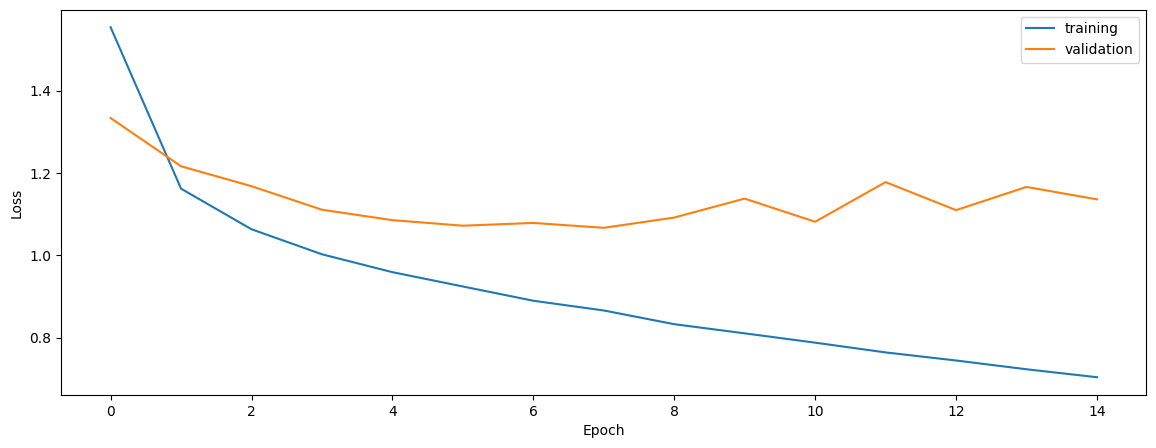

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6781831569780409
0.5843443863328643
0.6296731003303774


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.6299693148733846
0.5841615396750276
0.5480541053630754


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6447438902426563
0.6149225840896957
0.5722530521642619


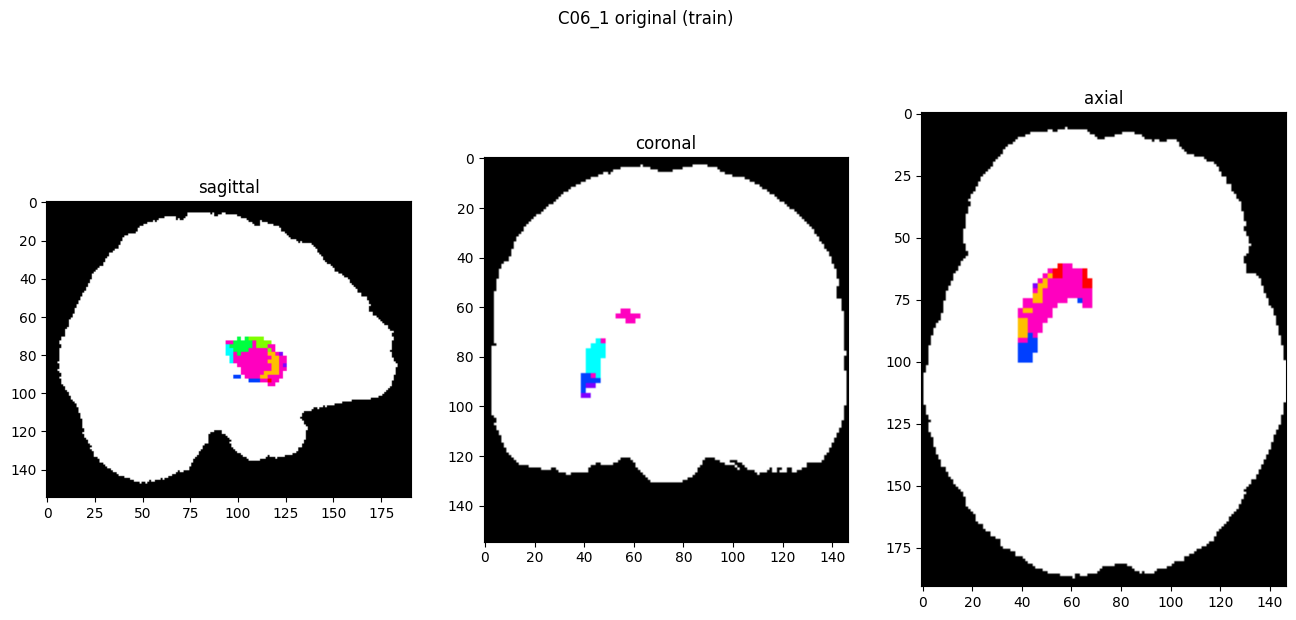

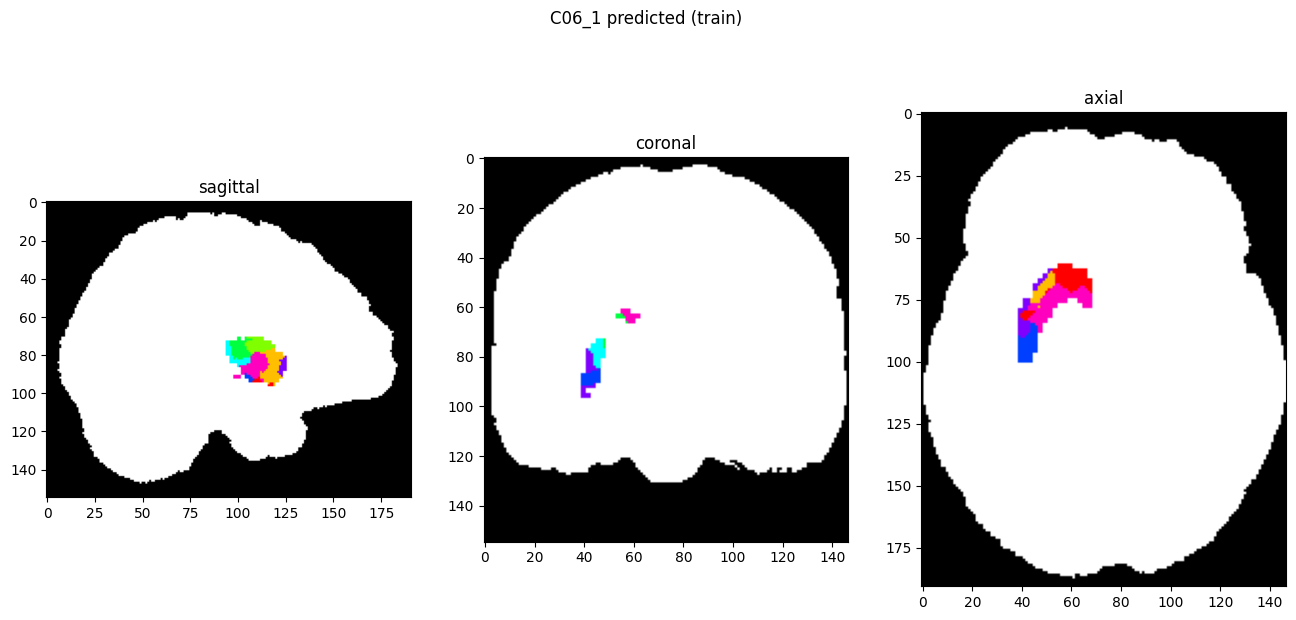

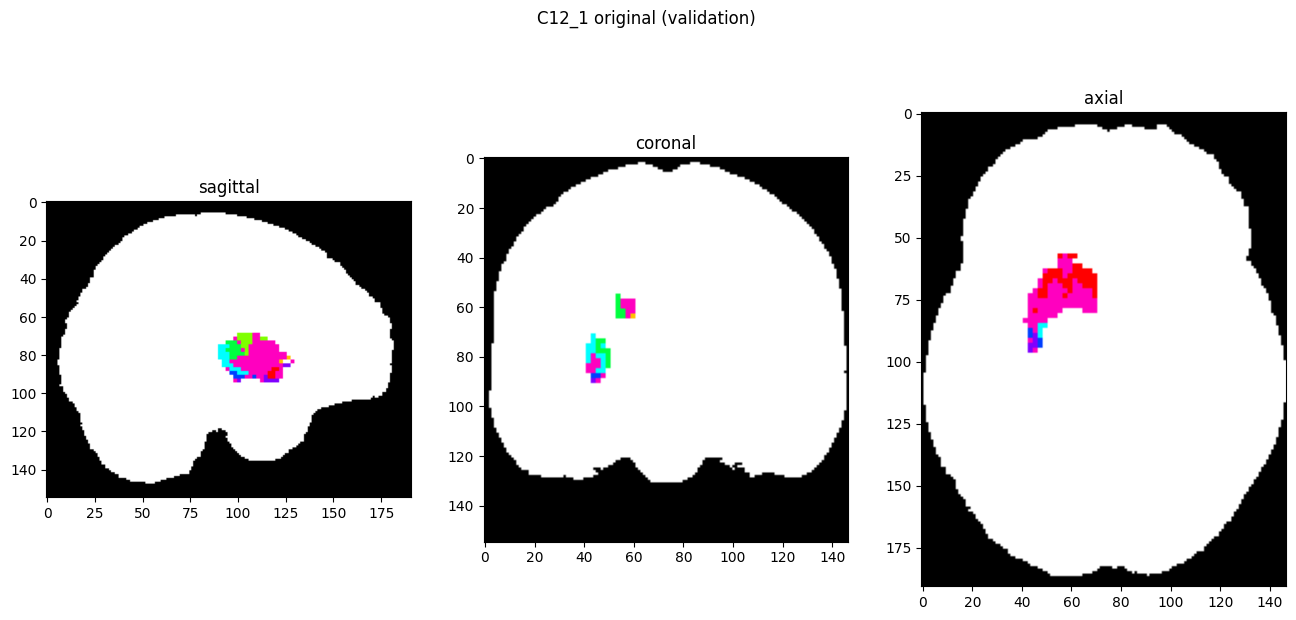

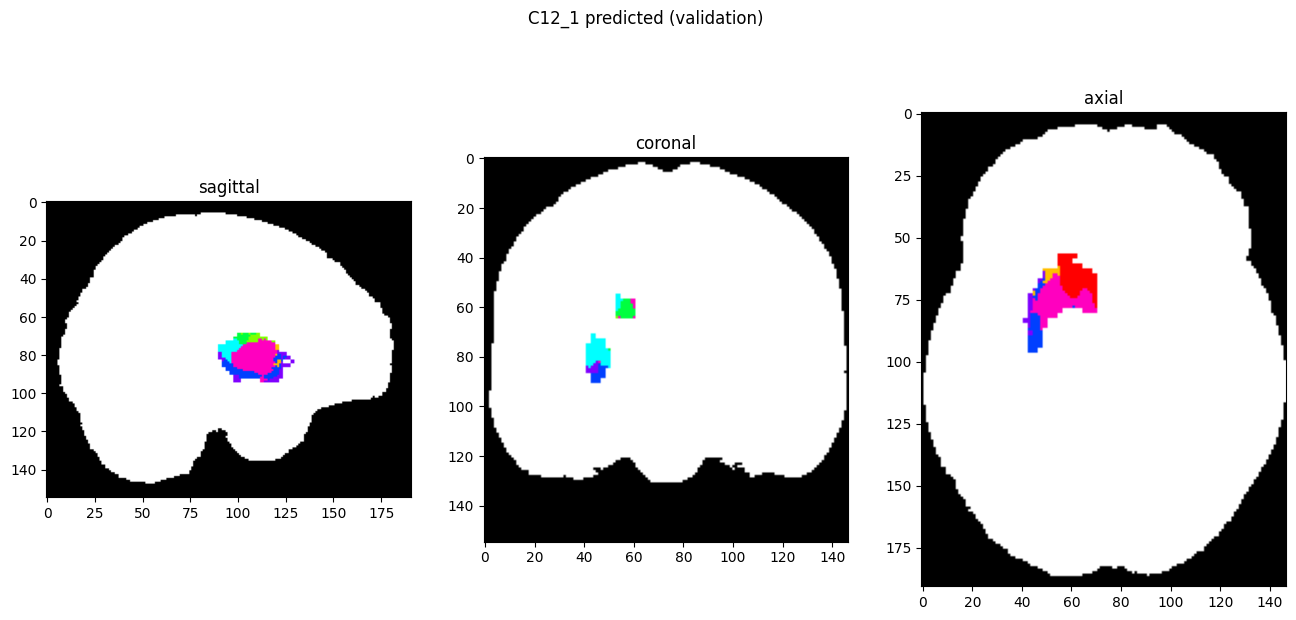

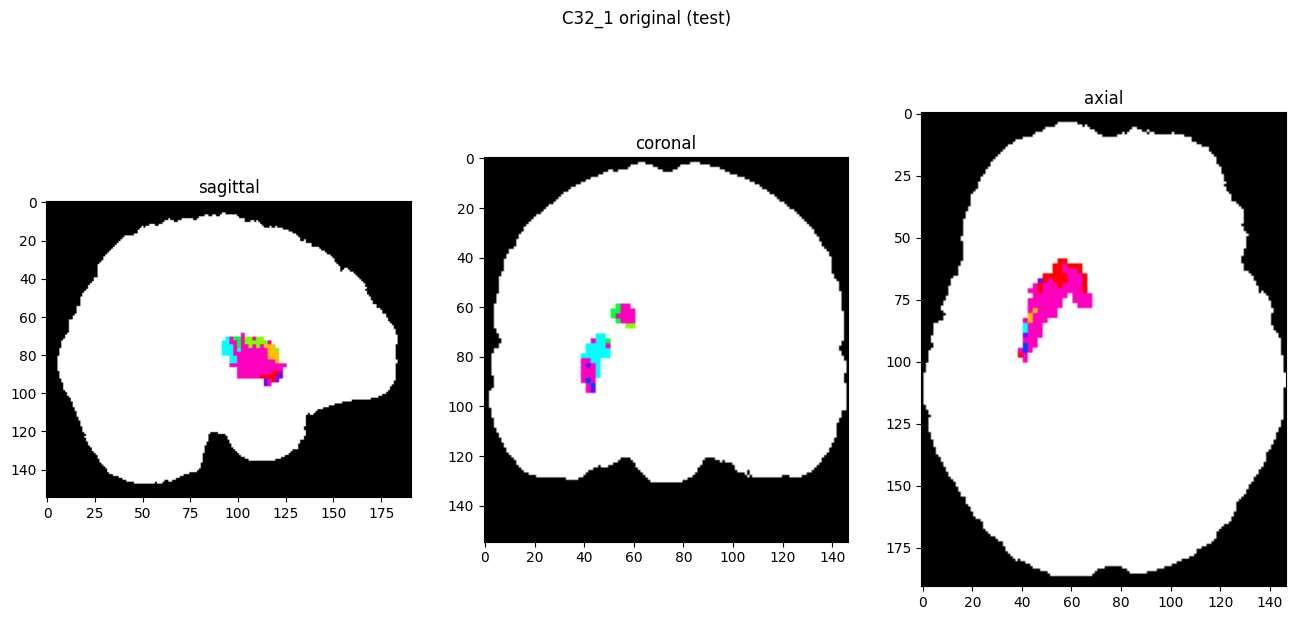

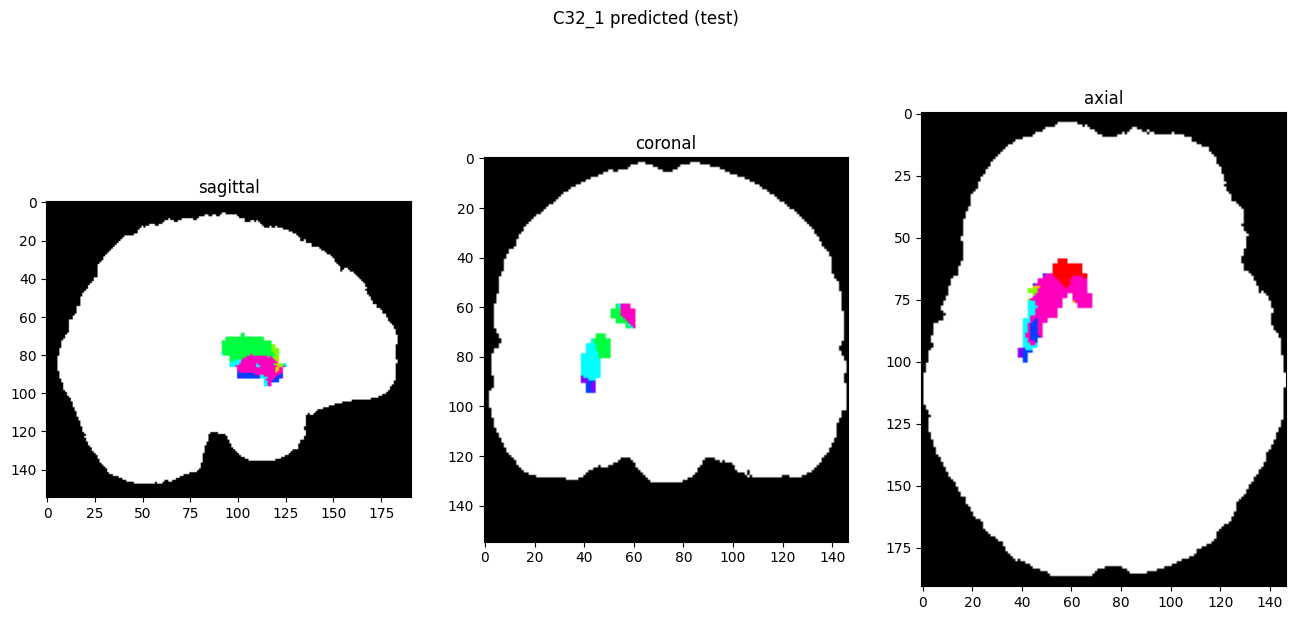

In [10]:
showResults(model, gen, threshold=0)